# ДИПЛОМНЫЙ ПРОЕКТ "Модель прогнозирования стоимости жилья для агенства недвижимости"

## БРИФ. Постановка цели и задач.

<span style=color:green>Цель</span> - разработать модель, которая позволила бы агенству недвижимости обойти конкурентов по скорости и качеству сделок.  

<span style=color:green>задачи:</span>

* очистить данные от выбросов и мусора;
* провести расведовательный анализ;
* построить несколько моделей и выбрать демонстрирующую лучший результат;
* разработать небольшой веб-сервис, принимающий данные об объекте, возвращающих прогноз стоимости.

<p><span id="TOC"></span></p>

**ОГЛАВЛЕНИЕ**
<p> <a href="#1">1.ПОДГРУЗКА ДАННЫХ И НЕОБХОДИМЫХ БИБЛИОТЕК</a></p>
<p> <a href="#2">2.ЗНАКОМСТВО С ДАННЫМИ</a></p>
<p> <a href="#3">3.ОЧИСТКА ДАННЫХ</a></p>
<p> <a href="#4">4.СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАНННЫХ</a></p>
<p> <a href="#5">5.КОДИРОВАНИЕ ПРИЗНАКОВ</a></p>
<p> <a href="#6">6.МОДЕЛИРОВАНИЕ</a></p>


<a name="pookie"></a>

## 1. ПОДГРУЗКА ДАННЫХ И НЕОБХОДИМЫХ БИБЛИОТЕК

<p><span id="#1"></span></p>

In [1]:
import numpy as np
import pandas as pd

import re
from itertools import chain

from geopy.geocoders import Nominatim
from fake_useragent import UserAgent
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.exc import GeocoderServiceError



import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import sklearn.metrics as metrics


import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
df = pd.read_csv('data/data.csv/data.csv')

## 2. ЗНАКОМСТВО С ДАННЫМИ

<p><span id="2"></span></p>

In [3]:
df.head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

**Описание данных:**  
* <span style=background-color:#D3D3D3>'status'</span> — статус продажи;  
* <span style=background-color:#D3D3D3>'private pool'</span> и <span style=background-color:#D3D3D3>'PrivatePool'</span> — наличие собственного бассейна;  
* <span style=background-color:#D3D3D3>'propertyType'</span> — тип объекта недвижимости;  
* <span style=background-color:#D3D3D3>'street'</span> — адрес объекта;  
* <span style=background-color:#D3D3D3>'baths'</span> — количество ванных комнат;  
* <span style=background-color:#D3D3D3>'homeFacts'</span> — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);  
* <span style=background-color:#D3D3D3>'fireplace'</span> — наличие камина;  
* <span style=background-color:#D3D3D3>'city'</span> — город;  
* <span style=background-color:#D3D3D3>'schools'</span> — сведения о школах в районе;  
* <span style=background-color:#D3D3D3>'sqft'</span> — площадь в футах;  
* <span style=background-color:#D3D3D3>'zipcode'</span> — почтовый индекс;  
* <span style=background-color:#D3D3D3>'beds'</span> — количество спален;  
* <span style=background-color:#D3D3D3>'state'</span> — штат;  
* <span style=background-color:#D3D3D3>'stories'</span> — количество этажей;  
* <span style=background-color:#D3D3D3>'mls-id'</span> и <span style=background-color:#D3D3D3>'MlsId'</span> — идентификатор MLS (Multiple Listing Service, система мультилистинга);  
* <span style=background-color:#D3D3D3>'target'</span> — цена объекта недвижимости (**целевой признак, который необходимо спрогнозировать**).

#### Важные сведения о данных:


1. Признаки <span style=background-color:#D3D3D3>'homeFacts'</span> и <span style=background-color:#D3D3D3>'schools'</span> представляют собой словари и содержат несколько типов сведений. Необходимо десериализовать содержимое этих признаков. Если в нём есть полезные данные, необходимо создать из них новые признаки.

2. Типы жилья (может пригодиться при обработке признака <span style=background-color:#D3D3D3>propertyType</span>): 
    * **apartment** — съёмная квартира (нельзя купить); 
    * **condo** — кондоминиум (можно купить); 
    * **co-op** — квартира в жилищном кооперативе;
    * **single-family (detached, tiny home)** — односемейный (отдельный, маленький) дом;
    * **townhome, townhouse** — таунхаус;

3. Основные характеристики  жилья (может пригодиться при
обработке признака <span style=background-color:#D3D3D3>propertyType</span>): 
    * **cape cod** — черепичная крыша, облицовка деревянным сайдингом, дверь в центре здания, окна по бокам, один-два этажа; 
    * **colonial home** — минимум два этажа, симметрия, лестница в центре здания, строгий внешний вид; 
    * **contemporary** — чистые, простые линии, нейтральные цвета, натуральные текстуры;
    * **cottage** — небольшая уютная веранда, небольшие жилые помещения;
    * **craftsman** — деревянные элементы ручной работы, выступающие балки, большие колонны;
    * **Greek revival** — большие белые колонны, украшения в греческом стиле, нарядный вход;
    * **farmhouse** — прямоугольная планировка, большое крыльцо, амбарная крыша;
    * **French country** — влияние прованса, облицовка камнем, состаренный вид;
    * **Mediterranean** — белая штукатурка, дерево и камень в тёплых тонах, черепичные крыши, элементы испанских и итальянских вилл;
    * **midcentury modern** — сочетание плавных природных и строгих геометрических линий, гладкость, лаконичность, большие окна;
    * **ranch** — один этаж, низкая крыша, открытые жилые помещения, задний двор;
    * **split-level** — жилые помещения разделены короткими лестничными пролётами;
    * **Tudor** — деревянные балки, каменная кладка, асимметричная крутая двускатная крыша;
    * **Victorian (Queen Anne Houses)** — два-три и более этажей, богатый декор, крутая двускатная крыша, небольшие башенки, яркий фасад;
    * **European Houses style** — кирпич или камень, высокая крутая крыша, высокие окна, часто со ставнями, традиционные декоративные детали (фронтоны, замковые камни);
    * **log home** — деревянный дом.

4. Некоторые жаргонные сокращения — для исправления дублирования (может пригодиться при обработке признака <span style=background-color:#D3D3D3>propertyType</span>):
    * **manufactured home (house)** = **mobile** = **prefab** = **modular**; 
    * **mobile** = **mo2 le** = **mo2le**; 
    * **cabin** = **ca2 n** = **ca2n**; 
    * **midcentury** = **mid century** = **mid-century**;
    * **single family** = **single-family home**.
    
5. Некоторые термины, используемые в сфере купли-продажи недвижимости:
    * **status** — статус, состояние. 
    * **estate** — объект недвижимости. 
    * **foreclosed** (**foreclosure**) — «лишён права выкупа». *Это процесс, когда недвижимость переходит к кредитору из-за неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости отличается от традиционных продаж.*
    * **pre foreclosure** (**pre foreclosure auction**) — «до выкупа», «аукцион до выкупа».
    * **under contract showing** (**under contract show**, **under contract**, **active under contract**) — предложение о покупке уже сделано, но не принято продавцом окончательно, и недвижимость продолжают показывать другим потенциальным покупателям.
    * **under contract backups**, **active backup**, **backup contract** — предложение о покупке уже сделано и принято продавцом, однако он открыт для резервных предложений. 
    * **contingency** — дополнительные обстоятельства (критерии, которым должен соответствовать продавец/покупатель до завершения сделки).
    * **contingency contract** — контракт на случай возникновения дополнительных обстоятельств.
    * **active contingency** — сделка уже практически состоялась, однако продавцу/покупателю для её завершения необходимо выполнить какие-то условия.
    * **insp inspection contingency** — ситуация, когда покупатель может официально проинспектировать объект недвижимости в определённый период времени.
    * **pending escape clause** — договор, предполагающий свободный выход сторон из него.
    * **pending backup wanted** — договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям и принимать резервные предложения.
    * **pending take backups** — условие, предполагающее, что продавец может принимать резерные предложения, если сделка с текущим покупателем не состоится.
    * **pending continue show** — договор уже заключен, однако продавец хочет продолжать показывать недвижимость другим потенциальным покупателям на случай, если текущая сделка не состоится.
    * **pending inspection** — «в ожидании инспекции».
    * **due diligence period** — период, в течение которого покупатель имеет право проинспектировать недвижимость и изучить всю важную для заключения сделки информацию.
    * **activated** — «активен», открыт для покупки.
    * **active with contract** — продавец уже принял предложение о покупке, однако сделка ещё не закрыта.
    * **active with offer** — продавец принял предложение о покупке, однако ищет резервные предложения на случай, если сделка с текущим покупателем не состоится.
    * **active auction**, **auction active**, **auction** — продажа недвижимости с помощью аукциона.
    * **cooling-off period** — период, в течение которого покупатель может расторгнуть договор после завершения сделки.

<p> <a href="#TOC">ОГЛАВЛЕНИЕ</a></p>

## 3. ОЧИСТКА ДАННЫХ

<p><span id="3"></span></p>

Посмотрим на количество дублирующих наблюдения в данных:

In [5]:
dubl = df.duplicated().sum()
print(f'В данных содержится {dubl} дубликатов')

В данных содержится 50 дубликатов


Удалим дубликаты:

In [6]:
df = df.drop_duplicates(ignore_index=True)

Посмотрим на количество пропусков в признаках:

In [7]:
# общщее колличество пропусков по каждому признаку
missings = df.isnull().sum()
missings

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274023
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150673
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

In [8]:
# пропуски в признаках в процентном соотношении
for col_name, missings_count in missings.items():
    if missings_count > 0:
        percents = (missings_count / len(df)) * 100
        print(col_name, round(percents,2),'%')
        

status 10.58 %
private pool 98.89 %
propertyType 9.21 %
street 0.0 %
baths 28.19 %
fireplace 72.66 %
city 0.01 %
sqft 10.75 %
beds 24.2 %
stories 39.95 %
mls-id 93.39 %
PrivatePool 89.31 %
MlsId 17.73 %
target 0.66 %


### 3.1.Признаки private pool и PrivatePool

Признаки **private pool** и **PrivatePool** содержат более 80% пропусков.

Согласно брифу Признаки **private pool** и **PrivatePool** содержат одинаковую информацию: наличие или отсутствие собственного бассейна. Вероятно, один содержит данные отсутсвующие в другом, а второй данные отсутсвующие в первом. Посмотрим на их содержание:

In [9]:
print('Уникальные значения в параметре private pool:', df['private pool'].unique())
print('Уникальные значения в параметре PrivatePool:', df['PrivatePool'].unique())

Уникальные значения в параметре private pool: [nan 'Yes']
Уникальные значения в параметре PrivatePool: [nan 'yes' 'Yes']


Признак **PrivatePool** содержит три варианта значения, в то время как **private pool** только два. Приведем к единообразию и объединим признаки:

In [10]:
df['PrivatePool'] = df['PrivatePool'].replace('yes', 'Yes')
#объединим два параметра используя метод DataFrame.combine_first, чтобы заполнить пропуски одного значением другого
df['PrivatePool'] = df['private pool'].combine_first(df['PrivatePool'])
# удалим столбец private pool
df = df.drop('private pool', axis=1)
#посмотрим на кол-во пропусков PrivatePool после объединения
print(df['PrivatePool'].isnull().sum())

332644


Пропуски в признаке **PrivatePool** указывают на отсутсвие собственного басейна, булево закодируем признаки, пусть наличие басейна будет *True*, а отсутсвие - *False*:

In [11]:
#заменим NaN значение на False
df['PrivatePool'] = df['PrivatePool'].fillna(False)
#заменим значение Yes на True
df['PrivatePool'] = df['PrivatePool'].replace('Yes', True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   propertyType  342402 non-null  object
 2   street        377133 non-null  object
 3   baths         270827 non-null  object
 4   homeFacts     377135 non-null  object
 5   fireplace     103112 non-null  object
 6   city          377101 non-null  object
 7   schools       377135 non-null  object
 8   sqft          336585 non-null  object
 9   zipcode       377135 non-null  object
 10  beds          285881 non-null  object
 11  state         377135 non-null  object
 12  stories       226462 non-null  object
 13  mls-id        24942 non-null   object
 14  PrivatePool   377135 non-null  bool  
 15  MlsId         310266 non-null  object
 16  target        374655 non-null  object
dtypes: bool(1), object(16)
memory usage: 46.4+ MB


Посмотрим на дубликаты после преобразования признака **PrivatePool**:

In [13]:
df.duplicated().sum()

0

### 3.2.Признак fireplace

In [14]:
#посмотрим на общее кол-во уникальных значений признака
df['fireplace'].str.lower().nunique()

1652

In [15]:
#посмотрим на распределение уникальных значений признака
df['fireplace'].str.lower().value_counts().head(30)

yes                          71209
1                            14544
2                             2432
not applicable                1993
fireplace                      847
3                              564
living room                    433
location                       399
wood burning                   311
gas/gas logs                   300
no                             289
fireplace yn                   287
special features               279
1 fireplace                    274
0                              271
familyrm                       246
fireplace features             239
great room                     207
wood                           206
gas logs, great room           188
ceiling fan                    186
living room, wood burning      185
4                              184
family room, wood burning      149
familyrm, gas logs             146
gas                            134
gas logs, in great room        112
gas logs                       107
gas logs, in living 

Признак **fireplace** содержит множество различных вариаций, однако приобладающим значением является '*yes*'. По сути, его значимость заключается в определении наличия или отсутсвия камина. Давайте его бинарно закодируем. Наличие камина будет True, отсутсвие - False:

In [16]:
df['fireplace'] = df['fireplace'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none', '0', 'not applicable', 'no'] and not pd.isna(x) else False)

In [17]:
# посмотрим на соотношение вариаций признака после кодирования
df['fireplace'].value_counts()


False    274295
True     102840
Name: fireplace, dtype: int64

### 3.3.Признак propertyType

Посмотрим на количество уникальных значений в **propertyType**:

In [18]:
df['propertyType'].nunique()

1280

Посмотрим на распределение уникальных значений:

In [19]:
df['propertyType'].value_counts().head(40)

single-family home               92199
Single Family                    62867
Single Family Home               31728
condo                            25964
lot/land                         20526
Condo                            16561
townhouse                        11456
Land                             10934
multi-family                      7900
Condo/Townhome/Row Home/Co-Op     7701
Townhouse                         6936
Traditional                       5913
coop                              3265
Multi Family                      2793
High Rise                         1823
Ranch                             1781
mobile/manufactured               1618
Detached, One Story               1614
Single Detached, Traditional      1581
Contemporary                      1557
Multi-Family Home                 1501
1 Story                           1234
Colonial                          1205
Mobile / Manufactured             1066
Contemporary/Modern               1000
2 Stories                

Видим, что многие значения различаются по форме написания, но суть есть одно. Преобразуем их, а также сформируем значение *Other* из значений не описывающих тип недвижимости:

In [20]:
#преобразуем все значения к строчному написанию
df.propertyType = df.propertyType.str.lower()
#приведем написание к единой форме,  так же заменим yes и unknown на Other
df.propertyType = df.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family') \
.str.replace('yes','Other') \
.str.replace('unknown','Other')
    
#выведем количество уникальных значений после преобразования
print('Количество уникальных значений после преобразования:{}'.format(df['propertyType'].nunique()))


Количество уникальных значений после преобразования:1269


В признаке много значений выполненных в форме перечисления через запятую, так же большое количество синонимов. Приобразуем эти данные:

In [21]:
#избавимся от избыточной информации
df['propertyType'] = df['propertyType'].str.split(',').str[0]
#функция преобразования синонимов
def syn_rename(value):
    for key, syn_val in synonyms.items():
        if value in syn_val:
            return key
    return 'other'

#словарь синонимов
synonyms = {
    'single_family_home': [
        'single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide', 'single-wide mobile with land',
        'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional'],
    'multi_family_home': [
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2 unit condo', '2-story'],
    'condo': [
        'condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse', 'co-op', '2 story condo', 'high rise'],
    'townhouse': [
        'townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': [
        'apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': [
        'lot/land', 'land'],
    'mobile_home': [
        'mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide', 'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'miscellaneous': [
        'miscellaneous'],
    'ranch': [
        'ranch', 'one story'],
    'modern': [
        'contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': [
        'historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': [
        'Other', 'english', 'urban contemporary', 'other style', 'florida', 'farms/ranches', 'carriage house', 'country english', 'straight thru', 'less than 4 floors', 'bungalow', 'custom', 'arts & crafts', 'tudor', 'new build 2019', 'split foyer', 'cottage', 'cottage/camp', 'garden home', 'farm/ranch', 'farm/ranch house', 'farm house', 'hi ranch', 'attached duplex', 'farmhouse', 'houseboat', 'ground floor', 'victorian', '3 story', '3+ stories', 'santa barbara/tuscan', 'old style', 'modular/prefab', 'post and beam', 'manuf/mobile', 'multiple occupancy', 'attached', 'hawaiian plantation', 'forest garden home', '1 1/2 story with basement', 'split-entry', 'texas hill country', 'lake house', '1 story with basement', 'hi-rise', 'coastal beach home', 'historical', 'key west/coastal', 'loft/balcony', 'english manor', 'mid-rise (4-7 stories)', 'mid-level', 'new englander', 'residential (<1 acre)', 'ranch','residential (1+ acre)', 'split', 'split level', 'split (4 level)', 'split (5+ level)', 'urban', 'patio', 'patio home', 'penthouse', 'manor', 'victorian/federal', 'coastal', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'mountain contemporary', 'key west', 'high ranch', 'end unit']
}

#преобразуем синонимы в нашем признаке
df['propertyType']= df['propertyType'].apply(syn_rename)

#смотрим количество пропусков и уникальных значений после приобразования
print(f'количество пропусков:{df.propertyType.isna().sum()}\n'
      f'количество уникальных значений:{df.propertyType.nunique()}\n'
      f'уникальные значения:\n{df.propertyType.value_counts()}')

количество пропусков:0
количество уникальных значений:12
уникальные значения:
single_family_home    195937
condo                  56958
other                  51584
land                   31460
townhouse              18543
multi_family_home      12349
mobile_home             3551
modern                  3252
ranch                   2033
apartment               1308
miscellaneous             96
historical                64
Name: propertyType, dtype: int64


### 3.4.Признак stories

Признак **stories** содержит информацию об количестве этажей. Посмотрим на признак:

In [22]:
print(f"Количество уникальных значений:{df['stories'].nunique()}")
print(f"количество пропусков:{df['stories'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['stories'].isna().sum()/len(df)*100,2)}%")
print(f"распределение значений:\n{df['stories'].value_counts()}")

Количество уникальных значений:348
количество пропусков:150673
Количество пропусков в процентном отношении:39.95%
распределение значений:
1.0                                  67451
2.0                                  55283
1                                    23085
2                                    18146
3.0                                  11272
                                     ...  
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
One, Two, Multi/Split                    1
65.0                                     1
Name: stories, Length: 348, dtype: int64


Посмотрим на распределение пропусков по типам объектов:

In [23]:
df[df.stories.isna()].propertyType.value_counts()

single_family_home    46341
other                 37042
land                  28883
condo                 24360
multi_family_home      5212
townhouse              3939
mobile_home            1499
ranch                  1389
modern                 1129
apartment               824
historical               44
miscellaneous            11
Name: propertyType, dtype: int64

Значение признака **stories** *single_family_home* наиболее представленно в данных, и может быть представлен как одноэтажными так и иными по этажности домами, посмотрим на отношение пропущенных данных по этому значению:

In [24]:
selected_sfh = df[(df.stories.isna()) & (df['propertyType'] == 'single_family_home')]
percent_sfh = len(selected_sfh)/len(df)*100
single_family_home = df[(df['propertyType'] == 'single_family_home')]
percent_single_family_home = len(selected_sfh)/len(single_family_home)*100

print(f"Количество пропусков в признаке stories по типу single_family_home в отношении ко всему объему данных: {round(percent_sfh,2)}%")
print(f"Количество пропусков в признаке stories по типу single_family_home в отношении к всему объему single_family_home: {round(percent_single_family_home,2)}%")

Количество пропусков в признаке stories по типу single_family_home в отношении ко всему объему данных: 12.29%
Количество пропусков в признаке stories по типу single_family_home в отношении к всему объему single_family_home: 23.65%


В признаке 39.95% пропусков распределенные по всем типам объектов, так же присутствует некоторое количество текстовых значений. И если в случае с land, condo, apartment, mobile_home, ranch мы можем принять условность, что этажность может быть ровна 0, то с остальными признаками - нет. Поиск и заполнение данных по каждому объекту не целесообразно, лучше удалить этот признак:

In [25]:
df = df.drop('stories', axis=1)

### 3.5.Признак street

Признак **street** содержит информацию об адресе объекта. Посмотрим нуждается ли он в оптимизации:

In [26]:
df['street'].value_counts()

Address Not Disclosed        672
Undisclosed Address          517
(undisclosed Address)        391
Address Not Available        175
Unknown Address               72
                            ... 
1737 Parkview Green Cir        1
14890 Rockridge Ln             1
497 Kingswood Dr               1
202 Seacrest Beach Blvd W      1
5983 Midcrown Dr               1
Name: street, Length: 337076, dtype: int64

In [27]:
df['street'].isna().sum()

2

Мы имеем два пропуска и множестно значений обозначающих, что адрес не разглашается, либо недоступен, либо неизвестен. Примим идею, что все эти значения есть суть одно, объединим их, отнесем к ним пропуски:

In [28]:
#список синонимов
disclosed_adress = {
    'Undisclosed Address':['Address Not Disclosed', 'Undisclosed Address','(undisclosed Address)','Address Not Available', 'Unknown Address']
}
#функция замены синонимов
def undisclosed_Address(value):
    for key, val in disclosed_adress.items():
        if value in val:
            return key
    return value
#заменяем синонимы
df['street'] = df['street'].apply(undisclosed_Address)    
#заменяем пропуски на Undisclosed Address        
df['street'] = df['street'].fillna('Undisclosed Address')        

df['street'].value_counts()

Undisclosed Address          1829
2103 E State Hwy 21            57
11305 Gulf Fwy                 54
17030 Youngblood Rd.           38
NE 58th Cir                    34
                             ... 
1737 Parkview Green Cir         1
14890 Rockridge Ln              1
497 Kingswood Dr                1
202 Seacrest Beach Blvd W       1
5983 Midcrown Dr                1
Name: street, Length: 337072, dtype: int64

In [29]:
df['street'].nunique()

337072

Оптимизируем варианты признака приведя к нижнему регистру:

In [30]:
df['street'] = df['street'].str.lower()

In [31]:
df['street'].nunique()

336262

### 3.6.Признак city

Есть пропуски попробуем востановить по признаку **zipcode** при помощи **geopy**:

In [32]:
#df_zip = df.copy()

In [33]:
#user_agent = UserAgent().random
#geolocator = Nominatim(user_agent=user_agent, timeout=10)

#def get_coordinates(address, retry_count=3):
#    if retry_count <= 0:
#       return None

#    try:
#        location = geolocator.geocode(address)
#        if location:
#            return (location.address)
#        else:
#            return None
#    except (GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError):
#        return get_coordinates(address, retry_count - 1)

#df_zip['location'] = df_zip['zipcode'].apply(get_coordinates)

In [34]:
#df_zip.head(5)

In [35]:
#df_zip[df_zip['city'].isna()]

In [36]:
#df_zip['city'].isna().sum()

Видим, что попытка решить через **geopy** не увенчалась успехом. Пропусков всего 34, заполним их в ручном режиме проверяя zip-code через https://tools.usps.com/  сверяя результат с кодом штата признака **state**:

In [37]:
df.at[7830,'city'] = 'Reddick'
df.at[21529,'city'] = 'MORRISTON'
df.at[26466,'city'] = 'LAREDO'
df.at[60990,'city'] = 'OCALA'
df.at[81509,'city'] = 'DUNNELLON'
df.at[122337,'city'] = 'OCALA'
df.at[123481,'city'] = 'PUNTA GORDA'
df.at[131266,'city'] = 'PORT CHARLOTTE'
df.at[151954,'city'] = 'OCALA'
df.at[170335,'city'] = 'KISSIMMEE'
df.at[171290,'city'] = 'LAREDO'
df.at[186779,'city'] = 'OCALA'
df.at[199648,'city'] = 'OCALA'
df.at[215069,'city'] = 'SILVER SPRINGS'
df.at[221264,'city'] = 'LAREDO'
df.at[221853,'city'] = 'LAREDO'
df.at[222785,'city'] = 'OCALA'
df.at[262327,'city'] = 'CLEVELAND'
df.at[270897,'city'] = 'LAREDO'
df.at[277436,'city'] = 'REDDICK'
df.at[278490,'city'] = 'KISSIMMEE'
df.at[281993,'city'] = 'KISSIMMEE'
df.at[304900,'city'] = 'KISSIMMEE'
df.at[309230,'city'] = 'KISSIMMEE'
df.at[312934,'city'] = 'DUNNELLON'
df.at[325746,'city'] = 'PUNTA GORDA'
df.at[331144,'city'] = 'OCKLAWAHA'
df.at[342308,'city'] = 'LAREDO'
df.at[346252,'city'] = 'MIAMI'
df.at[355353,'city'] = 'PUNTA GORDA'
df.at[358892,'city'] = 'KISSIMMEE'
df.at[370033,'city'] = 'HOUSTON'
df.at[370460,'city'] = 'OCKLAWAHA'

In [38]:
df[df['city'].isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,mls-id,PrivatePool,MlsId,target
130554,For sale,single_family_home,20003 mar rojo y mar egeo,Bathrooms: 6,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",False,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,A10761803,True,NaN,"$1,650,000"


Один объект имеет несоответсвие индекса и штата, также в признаке **street** указано что-то странное. Удалим его:

In [39]:
df = df.drop([130554])
print(f'колличество пропусков в признаке city:{df.city.isna().sum()}')

колличество пропусков в признаке city:0


Приведем признак к нижнему регистру:

In [40]:
df['city'] = df['city'].str.lower()

### 3.7.Признак Status

Признак **Status** содержит информацию о статусе продажи объекта. Посмотрим на количество уникальных значений, пропусков:

In [41]:
print(f'количество пропусков:{df.status.isna().sum()}\n'
      f'количество уникальных значений:{df.status.nunique()}\n'
      f'распределение значений признака:\n{df.status.value_counts()}')

количество пропусков:39917
количество уникальных значений:159
распределение значений признака:
for sale                156058
Active                  105207
For sale                 43463
foreclosure               6425
New construction          5474
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 159, dtype: int64


In [42]:
print(f"уникальные значения:{df['status'].sort_values().unique()}\n")

уникальные значения:[' / auction' 'A Active' 'Accepted Offer' 'Accepting backups' 'Active'
 'Active - Auction' 'Active - Contingent' 'Active Backup'
 'Active Contingency' 'Active Contingent' 'Active Option'
 'Active Option Contract' 'Active Under Contract'
 'Active With Contingencies' 'Active With Offer' 'Active with Contract'
 'Active/Contingent' 'Apartment for rent' 'Auction' 'Auction - Active'
 'Back On Market' 'Back on Market' 'Backup' 'Backup Contract' 'C'
 'C Continue Show' 'CT Insp - Inspection Contingency' 'Closed'
 'Coming soon: Dec 1.' 'Coming soon: Dec 10.' 'Coming soon: Dec 11.'
 'Coming soon: Dec 12.' 'Coming soon: Dec 13.' 'Coming soon: Dec 14.'
 'Coming soon: Dec 15.' 'Coming soon: Dec 16.' 'Coming soon: Dec 18.'
 'Coming soon: Dec 2.' 'Coming soon: Dec 20.' 'Coming soon: Dec 23.'
 'Coming soon: Dec 24.' 'Coming soon: Dec 25.' 'Coming soon: Dec 27.'
 'Coming soon: Dec 3.' 'Coming soon: Dec 4.' 'Coming soon: Dec 5.'
 'Coming soon: Dec 6.' 'Coming soon: Dec 7.' 'Coming soo

Видим, что некоторые значения дублируются (различаются сокращением, регистром), так же присутствует признак *Coming soon*. Пропуски заменим на *No info*. Выполним необходимые преобразования:

In [43]:
#нормализуем регистра
df['status'] = df['status'].str.lower()
#словарь синонимов
stasus_synonims = {
    'pending':['option pending' ,  'pending (do not show)', 'pending ab',  'pending fe', 'pending offer approval',  'pending sh', 'pending w/escape clause', 'p', 'pending'],
    
    'pending Continue To Show':['pending   continue to show', 'pending - continue to show', 'pending continue to show', 'pending, continue to show', 'pending   continue to show   financing'],
      
    'Pending With Contingencies':['pending with contingencies','pending w/ cont.'],
    
    'Pending Inspection':['pending inspection', 'pending w/insp finance', 'pending in', 'pi'],
    
    'Pending Sale':['pending sale', 'p pending sale'],
    
    'Pending Taking Backups':['pending taking backups', 'pending - paking backups', 'pending bring backup', 'pending - backup offer requested','pending backups wanted', 'pending take backups', 'pending w/backup wanted'],
    
    'auction':[' / auction', 'a active', 'active', 'active - auction', 'auction - active', 'auction'],
    
    'closed':['c', 'closed'],  
    
    'Coming soon: Dec':['coming soon: dec 1.', 'coming soon: dec 10.', 'coming soon: dec 11.', 'coming soon: dec 12.', 'coming soon: dec 13.', 'coming soon: dec 14.',
                        'coming soon: dec 15.', 'coming soon: dec 16.', 'coming soon: dec 18.', 'coming soon: dec 2.', 'coming soon: dec 20.', 'coming soon: dec 23.',
                        'coming soon: dec 24.', 'coming soon: dec 25.', 'coming soon: dec 27.', 'coming soon: dec 3.', 'coming soon: dec 4.', 'coming soon: dec 5.',
                        'Coming soon: Dec 6.', 'Coming soon: Dec 7.', 'Coming soon: Dec 9.'],
    
    'Coming soon: Nov':['coming soon: nov 11.', 'coming soon: nov 12.', 'coming soon: nov 13.', 'coming soon: nov 14.', 'coming soon: nov 17.', 'coming soon: nov 19.',
                        'coming soon: nov 21.', 'coming soon: nov 22.', 'coming soon: nov 23.', 'coming soon: nov 25.', 'coming soon: nov 26.', 'coming soon: nov 27.',
                        'coming soon: nov 28.', 'coming soon: nov 29.', 'coming soon: nov 30.', 'coming soon: nov 5.', 'coming soon: nov 8.'],
    
    'Coming soon: Oct':['coming soon: oct 21.', 'coming soon: oct 24.', 'coming soon: oct 29.', 'coming soon: oct 30.'], 
    
    'Under Contract':['under contract', 'under contract'],
    
    'Under Contract Backups':['under contract backups', 'under contract taking back up offers', 'under contract w/ bckp'],
    
    'Under Contract Showing':['under contract   showing', 'uc continue to show', 'under contract - show',  'under contract show'],
    
    'Pre-foreclosure':[ 'pre-foreclosure', 'pf']
    
    }
#функция замены синонимов
def status_rename(value):
  for key, val in stasus_synonims.items():
    if value in val:
      return key
  return value
#заменяем синонимы
df['status'] = df['status'].apply(status_rename)
#заменяем пропуски на No info
df['status'] = df['status'].fillna('No info')

Смотрим на результаты после преобразования:

In [44]:
print(f'количество пропусков:{df.status.isna().sum()}\n'
      f'количество уникальных значений:{df.status.nunique()}\n'
      f'распределение значений признака:\n{df.status.value_counts()}')

количество пропусков:0
количество уникальных значений:83
распределение значений признака:
for sale                 199523
auction                  107160
No info                   39917
foreclosure                6768
pending                    6423
                          ...  
conting accpt backups         1
contingent   no show          1
conditional contract          1
contract                      1
backup                        1
Name: status, Length: 83, dtype: int64


### 3.8.Признак baths

Признак **baths** демонстрирует количество ванных комнат. Посмотрим на количество уникальных значений и пропусков:

In [45]:
print(f'количество пропусков:{df.baths.isna().sum()}\n'
      f'количество уникальных значений:{df.baths.nunique()}\n'
      f'распределение значений признака:\n{df.baths.value_counts()}')

количество пропусков:106308
количество уникальных значений:229
распределение значений признака:
2 Baths       52458
3 Baths       35503
2             20452
2.0           16575
4 Baths       14763
              ...  
4.75 Baths        1
5.25 Baths        1
41.0              1
1.8 Baths         1
44.0              1
Name: baths, Length: 229, dtype: int64


In [46]:
df[df.baths.isna()].propertyType.value_counts()

other                 39846
land                  27147
single_family_home    19121
condo                 11433
multi_family_home      2316
modern                 2278
townhouse              1556
ranch                  1518
apartment               701
mobile_home             353
historical               32
miscellaneous             7
Name: propertyType, dtype: int64

Посмотрим на значения представленные в признаке, интерпретируем нетепичные значения:

In [47]:
l=list(df['baths'].unique())
#l
selected_row = df[(df['baths'] == '1 / 1-0 / 1-0 / 1-0') | (df['baths'] == '2-1 / 2-1 / 1-1 / 1-1') | (df['baths'] == '1 / 1 / 1 / 1') | (df['baths'] == '3-1 / 2-2')\
    | (df['baths'] == '116 / 116 / 116') | (df['baths'] == '1-0 / 1-0 / 1')] 

display(selected_row)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,mls-id,PrivatePool,MlsId,target
24724,auction,multi_family_home,1811 beechwood ave,1-0 / 1-0 / 1,"{'atAGlanceFacts': [{'factValue': '1920', 'fac...",False,nashville,"[{'rating': ['6', '5', '3', '4', '5', 'NR', 'N...",2932,37212,3.0,TN,NaN,False,2081563,"$775,000"
63510,auction,multi_family_home,321 larkin springs rd,116 / 116 / 116,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",False,madison,"[{'rating': ['1', 'NR', '3', '1', '2', '1', 'N...",99999,37115,NaN,TN,NaN,False,2051320,"$1,600,000"
85354,auction,multi_family_home,6511 robertson ave,3-1 / 2-2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",False,nashville,"[{'rating': ['2', '4', '3', '3', '2', 'NR', 'N...",1939,37209,3.0,TN,NaN,False,2085088,"$5,750,000"
110090,auction,multi_family_home,3317 ezell rd,1 / 1 / 1 / 1,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",False,nashville,"[{'rating': ['2', '3', '2', '1', '2', '2', 'NR...",4408,37211,3.0,TN,NaN,False,2027355,"$985,000"
301145,auction,multi_family_home,214 3rd ave,2-1 / 2-1 / 1-1 / 1-1,"{'atAGlanceFacts': [{'factValue': '1900', 'fac...",False,nashville,"[{'rating': ['1', '2', '3', '1', '4', '10', 'N...",11740,37201,2.0,TN,NaN,False,2107281,"$7,450,000"
316452,auction,multi_family_home,126 welworth st,1 / 1-0 / 1-0 / 1-0,"{'atAGlanceFacts': [{'factValue': '1966', 'fac...",False,madison,"[{'rating': ['3', '2', '3', '1', '2', '1', 'NR...",1324,37115,2.0,TN,NaN,False,2094893,"$2,250,000"


Видим, что через */* указывается этаж и количество ванных на этаж, в одном объекте указано *116 / 116 / 116* (63510). Объект 63510 оказался землей под строительство многоквартирного дома, возможно 116 это число предполагаемых квартир, может нет. Площадь этого объекта так же указана случайным набором цивф *99999*, лучше его удалить.

Видим, что в значениях много буквенных литералов, распределение пропусков сконцентрированно в типе имущества *other, land*. Уберем буквенные значения, заполним пропуски в *other, land, ranch, mobile_home* на 0, вместо прочерков поставим 0, в остальных значения проставим соответствующее значение, объект под индексом 63510 - удалим, переведем данные признака в тип *float*: 

In [48]:
#убираем буквенные литералы
df['baths'] = df['baths'].str.replace('[a-zA-Z+:]','', regex=True)

#заменяем значения 
df['baths'].replace(['1 / 1 / 1 / 1','2-1 / 2-1 / 1-1 / 1-1'],4,inplace=True)
df['baths'].replace(['1-2 ','1-0 / 1-0 / 1','1 / 1-0 / 1-0 / 1-0'],1,inplace=True)
df['baths'].replace('3-1 / 2-2',3,inplace=True)
df['baths'].replace(['~','0 / 0','. . ','-- ','—',' ',''],0,inplace=True)
df['baths'].replace(['7,500'], 7.5, inplace=True)
df['baths'].replace(['5,000'], 5, inplace=True)
df['baths'].replace(['3,500'], 3.5, inplace=True)
df['baths'].replace(['2,750'], 2.75, inplace=True)
df['baths'].replace(['2,250'], 2.25, inplace=True)
df['baths'].replace(['1,250'], 1.25, inplace=True)
df['baths'].replace(['1,500'], 1.5, inplace=True)
df['baths'].replace(['4,000'], 4, inplace=True)
df['baths'].replace(['2,000'], 2, inplace=True)
df['baths'].replace(['3,000'], 3, inplace=True)
df['baths'].replace(['2,500'], 2.5, inplace=True)
df['baths'].replace(['1,000'], 1, inplace=True)
df['baths'].replace(['1,750'], 1.75, inplace=True)


#удаляем объект по индексу 63510
df['baths'] = df['baths'].drop([63510])
#заменяем NaN на 0
df['baths'] = df['baths'].fillna(0)

#переведем в тип float и округлим до целого
df['baths'] = df['baths'].astype(float).round()



Посмотрим на распределение нулевых значений:

In [49]:

selected_lands = df[(df['baths'] == 0) & ((df['propertyType'] == 'other') | (df['propertyType'] == 'land') | (df['propertyType'] == 'ranch'))]

percent_lands = len(selected_lands) / len(df) * 100

selected_no_lands = df[(df['baths'] == 0) & ~(df['propertyType'].isin(['other', 'land', 'ranch']))]

percent_no_lands = len(selected_no_lands) / len(df) * 100

print( f"Количество уникальных значений: {df.baths.nunique()}\n")
print(f"Количество нулевых значений во всех объектах:{percent_lands+percent_no_lands:.2f}%")
print(f"Процент нулевых значений в объектах типа other, land, ranch: {percent_lands:.2f}%")
print(f"Процент нулиеых значений в объектах не относящихся к типам other, land, ranch: {percent_no_lands:.2f}%")

Количество уникальных значений: 48

Количество нулевых значений во всех объектах:29.62%
Процент нулевых значений в объектах типа other, land, ranch: 19.37%
Процент нулиеых значений в объектах не относящихся к типам other, land, ranch: 10.25%


Таким образом у нас 29.62% объектов не имеют ванных комнат. Из их 19.37% объекты относящиеся к типу *другое* либо одному из типов земель, что представляется логиным. В остальных типах 10.25% объектов без ванной комнаты, что возможно.

### 3.9.Признак sqft

Признак **sqft** содержит информацию о площади объекта.Посмотрим на признак:

In [50]:
print(f"Количество уникальных значений:{df['sqft'].nunique()}")
print(f"количество пропусков:{df['sqft'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['sqft'].isna().sum()/len(df)*100,2)}%")
print(f"распределение значений:\n{df['sqft'].value_counts()}")

Количество уникальных значений:25404
количество пропусков:40550
Количество пропусков в процентном отношении:10.75%
распределение значений:
0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
1,800 sqft                                   563
                                           ...  
11,491                                         1
9,914                                          1
Total interior livable area: 3,055 sqft        1
5,177                                          1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25404, dtype: int64


В признаке присутствуют буквенные значения и пропуски, уберем их, переведем признак в int:

In [51]:
#выбираем все значения не nan
df_sqft = df.sqft[df.sqft.notna()]
#выбираем все "числовые" значения
df_sqft = df_sqft.str.findall(r"\d+")
#преобразуем 
df_sqft = df_sqft.apply(lambda x: ''.join(x))
#заполняем значения признака sqft получившимися значениями
df.loc[df.sqft.notna(), 'sqft']=df_sqft
#меняем пропуски на 0
df['sqft'] = df['sqft'].fillna(0)
#заменим пустые строки на 0
df.loc[df.sqft=='','sqft'] = 0
#приобразуем в тим int
df.sqft = df.sqft.astype(int)

In [52]:
print(f"Количество уникальных значений:{df['sqft'].nunique()}")
print(f"количество пропусков:{df['sqft'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['sqft'].isna().sum()/len(df)*100,2)}%")
print(f"распределение значений:\n{df['sqft'].value_counts()}")

Количество уникальных значений:9897
количество пропусков:0
Количество пропусков в процентном отношении:0.0%
распределение значений:
0          53224
1200        1426
1000        1027
1500        1014
1800         988
           ...  
5728968        1
12503          1
8815           1
15391          1
13870          1
Name: sqft, Length: 9897, dtype: int64


Посмотрем на распределение нулей по типам объектов:

In [53]:
selected_sfh = df[(df['sqft'] == 0) & (df['propertyType'] == 'single_family_home')]
percent_sfh = len(selected_sfh)/len(df)*100
single_family_home = df[(df['propertyType'] == 'single_family_home')]
percent_single_family_home = len(selected_sfh)/len(single_family_home)*100

selected_condo = df[(df['sqft'] == 0) & (df['propertyType'] == 'condo')]
percent_c = len(selected_condo)/len(df)*100
condo = df[(df['propertyType'] == 'condo')]
percent_condo = len(selected_condo)/len(condo)*100

selected_other = df[(df['sqft'] == 0) & (df['propertyType'] == 'other')]
percent_oth = len(selected_other)/len(df)*100
other = df[(df['propertyType'] == 'other')]
percent_other = len(selected_other)/len(other)*100

selected_land = df[(df['sqft'] == 0) & (df['propertyType'] == 'land')]
percent_la = len(selected_land)/len(df)*100
land = df[(df['propertyType'] == 'land')]
percent_land = len(selected_land)/len(land)*100

selected_townhouse = df[(df['sqft'] == 0) & (df['propertyType'] == 'townhouse')]
percent_tow = len(selected_townhouse)/len(df)*100
townhouse = df[(df['propertyType'] == 'townhouse')]
percent_townhouse = len(selected_townhouse)/len(townhouse)*100

selected_multi_family_home = df[(df['sqft'] == 0) & (df['propertyType'] == 'multi_family_home')]
percent_multi = len(selected_multi_family_home)/len(df)*100
multi_family_home = df[(df['propertyType'] == 'multi_family_home')]
percent_multi_family_home = len(selected_multi_family_home)/len(multi_family_home)*100

selected_mobile_home = df[(df['sqft'] == 0) & (df['propertyType'] == 'mobile_home')]
percent_mobile = len(selected_mobile_home)/len(df)*100
mobile_home = df[(df['propertyType'] == 'mobile_home')]
percent_mobile_home = len(selected_mobile_home)/len(mobile_home)*100

selected_modern = df[(df['sqft'] == 0) & (df['propertyType'] == 'modern')]
percent_mod = len(selected_modern)/len(df)*100
modern = df[(df['propertyType'] == 'modern')]
percent_modern = len(selected_modern)/len(modern)*100

selected_ranch = df[(df['sqft'] == 0) & (df['propertyType'] == 'ranch')]
percent_ran = len(selected_ranch)/len(df)*100
ranch = df[(df['propertyType'] == 'ranch')]
percent_ranch = len(selected_ranch)/len(ranch)*100

selected_apartment = df[(df['sqft'] == 0) & (df['propertyType'] == 'apartment')]
percent_apart = len(selected_apartment)/len(df)*100
apartment = df[(df['propertyType'] == 'apartment')]
percent_apartment = len(selected_apartment)/len(apartment)*100

selected_miscellaneous = df[(df['sqft'] == 0) & (df['propertyType'] == 'miscellaneous')]
percent_misc = len(selected_miscellaneous)/len(df)*100
miscellaneous = df[(df['propertyType'] == 'miscellaneous')]
percent_miscellaneous = len(selected_miscellaneous)/len(miscellaneous)*100

selected_historical = df[(df['sqft'] == 0) & (df['propertyType'] == 'historical')]
percent_hist = len(selected_miscellaneous)/len(df)*100
historical = df[(df['propertyType'] == 'historical')]
percent_historical = len(selected_miscellaneous)/len(historical)*100

type_zero = round((len(df[(df['sqft']==0)])/len(df)*100),2)

d = {'scope':['in', 'all'], 'single_family_home':[(round(percent_single_family_home,2)),(round(percent_sfh,2))],
     'condo':[(round(percent_condo,2)),(round(percent_c,2))],
     'other':[(round(percent_other,2)),(round(percent_oth,2))],
     'land':[(round(percent_land,2)),(round(percent_la,2))],
     'townhouse':[(round(percent_townhouse,2)),(round(percent_tow,2))],
     'multi_family_home':[(round(percent_multi_family_home,2)),(round(percent_multi,2))],
     'mobile_home':[(round(percent_mobile_home,2)),(round(percent_mobile,2))],
     'modern':[(round(percent_modern,2)),(round(percent_mod,2))],
     'ranch':[(round(percent_ranch,2)),(round(percent_ran,2))],
     'apartment':[(round(percent_apartment,2)),(round(percent_apart,2))],
     'miscellaneous':[(round(percent_miscellaneous,2)),(round(percent_misc,2))],
     'historical':[(round(percent_historical,2)),(round(percent_hist,2))]}
scope = pd.DataFrame(data=d)

display(scope)
print(f"Количество нулевых значений признака sqft от общего числа строк:{type_zero}%")


,scope,single_family_home,condo,other,land,townhouse,multi_family_home,mobile_home,modern,ranch,apartment,miscellaneous,historical
0,in,1.74,3.56,36.53,86.94,1.90,7.22,6.42,0.98,2.02,3.59,4.17,6.25
1,all,0.90,0.54,5.00,7.25,0.09,0.24,0.06,0.01,0.01,0.01,0.00,0.00


Количество нулевых значений признака sqft от общего числа строк:14.11%


Значительная часть находится в значениях other,land (12.25% от 14.11% нулей в признаке). Значения other и land имеют большое количество нулевых значения, что скажется на качестве предсказания по этим типам объекта. В значениях обозначающих типы строений только 2.14% нулевых значений, так что пока оставим как есть.

### 3.10.Признак beds

Признак **beds** указывает на количество спален в объекте. Посмотри на него:

In [54]:
print(f"Количество уникальных значений:{df['beds'].nunique()}")
print(f"количество пропусков:{df['beds'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['beds'].isna().sum()/len(df)*100,2)}%")
print(f"распределение значений:\n{df['beds'].value_counts()}")

Количество уникальных значений:1184
количество пропусков:91254
Количество пропусков в процентном отношении:24.2%
распределение значений:
3 Beds         53454
4 Beds         35412
3              31405
2 Beds         26355
4              20030
               ...  
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
5,510 sqft         1
8,479 sqft         1
Name: beds, Length: 1184, dtype: int64


Посмотрим на распределение пропусков по типу объекта:

In [55]:
df[df.beds.isna()].propertyType.value_counts()

other                 36492
land                  28854
condo                 10739
single_family_home     8349
modern                 2265
multi_family_home      1648
ranch                  1508
apartment               623
townhouse               571
mobile_home             171
historical               34
Name: propertyType, dtype: int64

In [56]:
l = list(df['beds'].unique())
#l

В признаке присутствует множестно данных отличных от количества кроватей, давайте посмотрим на количество значений с меткой *sqft* и *acres*, возможно ими можно заполнить пропуски в признаке **sqft**:

In [57]:
df['beds'].str.endswith('acres',na=False).value_counts()

False    375542
True       1592
Name: beds, dtype: int64

In [58]:
df['beds'].str.endswith('sqft',na=False).value_counts()

False    375699
True       1435
Name: beds, dtype: int64

Искомых значений оказалось незначительное количество. Обилие пропусков, мусорных данных делает признак **beds** бесполезным - удалим его:

In [59]:
df = df.drop('beds', axis=1)

### 3.11.Признак homeFacts

Признак **homeFacts** содержит сведения о строительстве объекта. Посмотрим на него:

In [60]:
print(f"Количество уникальных значений:{df['homeFacts'].nunique()}")
print(f"количество пропусков:{df['homeFacts'].isna().sum()}")
print(f"Количество пропусков в процентном отношении:{round(df['homeFacts'].isna().sum()/len(df)*100,2)}%")
print(f"распределение значений:\n{df['homeFacts'].value_counts()}")

Количество уникальных значений:321008
количество пропусков:0
Количество пропусков в процентном отношении:0.0%
распределение значений:
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                                       7174
{'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]}                                            3532
{'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'fact

Признак содержит две группы фактов об объекте *'factValue'* и *'factLabel'* объединенные в словарь. Изымим эти факты в отдельные признаки, посмотрим будут ли они нам полезны:

In [61]:
#С помощью регулярных выражений выдерним из признака значения для Value и Label
Value = df.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
label = df.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
#создадим список названий признаков, удалив лишние кавычки
list_label = ','.join(label[0]).replace("'","").split(',')
list_label

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [62]:
# Создадим эти признаки в нашем фрейме и заполним значениями
for i, val in enumerate(list_label):
    df[val]=Value.apply(lambda x: x[i])

Признак **homeFacts** более не нужен, удалим его:

In [63]:
df = df.drop('homeFacts', axis=1)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377134 entries, 0 to 377134
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          377134 non-null  object 
 1   propertyType    377134 non-null  object 
 2   street          377134 non-null  object 
 3   baths           377134 non-null  float64
 4   fireplace       377134 non-null  bool   
 5   city            377134 non-null  object 
 6   schools         377134 non-null  object 
 7   sqft            377134 non-null  int32  
 8   zipcode         377134 non-null  object 
 9   state           377134 non-null  object 
 10  mls-id          24941 non-null   object 
 11  PrivatePool     377134 non-null  bool   
 12  MlsId           310266 non-null  object 
 13  target          374654 non-null  object 
 14  Year built      377134 non-null  object 
 15  Remodeled year  377134 non-null  object 
 16  Heating         377134 non-null  object 
 17  Cooling   

#### Признак Year built

Признак **Year built** указывает на год строительства объекта, посмотрим на него:

In [65]:
df['Year built'].unique()[:10]

array(["'2019'", "'1961'", "'2006'", "''", "'1920'", "'1976'", "'1970'",
       "'1965'", "'2015'", "'1996'"], dtype=object)

Уберем ненужные ковычки:

In [66]:
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)

Изучем значения признака:

In [67]:
l = list(df['Year built'].unique())
#l

Есть дома со странными датами:

In [68]:
house_strange = df[(df['Year built'] == '1019') | (df['Year built'] == '1057') | (df['Year built'] == '1060')  | (df['Year built'] == '1') |
                   (df['Year built'] == '1208') | (df['Year built'] == '2025') | (df['Year built'] == '559990649990')]
house_strange

,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,state,...,PrivatePool,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
77797,auction,condo,12522 15th ave ne,2.0,False,seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...",1486,98125,WA,...,False,161732709,"$649,990",559990649990,'','','','',None,'$437'
120334,for sale,land,w trinity ln,0.0,False,nashville,"[{'rating': ['2/10', '1/10', 'None/10'], 'data...",1,37207,TN,...,False,1997063,"$5,950,000",1,'1111','','','','12.59 acres',"'$5,950,000/sqft'"
149913,Pending Inspection,single_family_home,648 n mulberry st,2.0,False,logan,"[{'rating': ['9', '6', '4', '6', 'NR', 'NR'], ...",1208,43138,OH,...,False,9922581,"$79,000",1208,'','GAS FORCED AIR','','888',None,'$65'
164154,auction,other,2421 flume gate ct,0.0,True,raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...",3518,27603,NC,...,False,2226990,"534,000",2025,'','','','','—','$152 / Sq. Ft.'
172710,auction,single_family_home,5532 nw 57th pl,2.0,False,ocala,"[{'rating': ['1', '4', '3', '1', '6', '5', 'NR...",1042,34482,FL,...,False,562474,"$104,900",1057,'','Central Electric','Central Electric','','8712','$101'
179733,for sale,land,5754 grande lagoon blvd,0.0,False,pensacola,"[{'rating': ['3/10', '7/10', '3/10'], 'data': ...",20900,32507,FL,...,False,501274,"$139,000",1,'','','','','0.48 acres','$7/sqft'
264030,auction,other,576 19th st,0.0,False,brooklyn,"[{'rating': ['6', '8', '5', '6'], 'data': {'Di...",1892,11218,NY,...,False,1131116,"1,499,999",1060,'1960','','','',"'1,953 Sq. Ft.'",'$793 / Sq. Ft.'
312838,auction,other,ellisway rd #13,3.0,False,charlotte,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1811,28216,NC,...,False,3564047,"285,500",1019,'','',"'Heat Pump for A/C, Heat Pump for Heat'",'','—','$158 / Sq. Ft.'
313472,auction,other,2405 flume gate ct,0.0,True,raleigh,"[{'rating': ['5', '4', '3'], 'data': {'Distanc...",3000,27603,NC,...,False,2226994,"494,990",2025,'','','','','0.77 Acres','$165 / Sq. Ft.'
354101,auction,condo,12522 15th ave ne,2.0,False,seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...",1233,98125,WA,...,False,161732708,"$559,990",559990649990,'','','','',None,'$454'


Домов со странными датами немного, их можно найти и внести вручную. Также есть *ковычки, None, No Data*, заменим их на *no info*:

In [69]:
df.at[77797,'Year built'] = '2021'
df.at[120334,'Year built'] = 'no info'
df.at[149913,'Year built'] = '1908'
df.at[164154,'Year built'] = '2021'
df.at[172710,'Year built'] = '1987'
df.at[179733,'Year built'] = 'no info'
df.at[264030,'Year built'] = '1960'
df.at[312838,'Year built'] = '2020'
df.at[313472,'Year built'] = '2020'
df.at[354101,'Year built'] = '2021'

df['Year built'] = df['Year built'].str.replace('^\s*$','no info', regex=True)

mask= df['Year built'].isin(['No Data','None'])
df.loc[mask,'Year built'] = 'no info'

Посмотрим на количество значений *no info* относительно датафрема в целом:

In [70]:
no_info_row = df[df['Year built'] == 'no info']

print(f"Количество значения 'no info' относительно датафрейма:{round(len(no_info_row)/len(df)*100,2)}%")

Количество значения 'no info' относительно датафрейма:16.86%


Допустим, данные о годе сроительства отсутствуют у типов объекта *other, land, ranch*. Посмотрим на количество значений *no info* относительно этих типа объекта:

In [71]:
no_info_row = df[(df['Year built'] == 'no info') & ((df['propertyType'] == 'other') | (df['propertyType'] == 'land') | (df['propertyType'] == 'ranch'))]

print(f"Количество значения 'no info' относительно other, land, ranch:{round(len(no_info_row)/len(df)*100,2)}%")

Количество значения 'no info' относительно other, land, ranch:11.89%


Таким образов видим, что данные о годе строительства отсутсвуют у 16.86% наблюдений, из них 11.89% это объекты other, land, ranch и 4.97% у других объектов, что является допустимым.

#### Признак Remodeled year

Признак **Remodeled year** указывает на год реконструкции объекта. Посмотрим на него:

In [72]:
#уберем ненужные ковычки
df['Remodeled year'] = df['Remodeled year'].str.replace("'",'', regex=True)
df['Remodeled year'].unique()[:10]

array(['', '1967', '2006', 'None', '2015', '1997', '2019', '1982', '1905',
       '2009'], dtype=object)

In [73]:
l = list(df['Remodeled year'].unique())
#l

Проверим, относится ли *None* приимущественно к other, land, ranch:

In [74]:
no_info_row = df[(df['Remodeled year'] == 'None') & ((df['propertyType'] == 'other') | (df['propertyType'] == 'land') | (df['propertyType'] == 'ranch'))]

print(f"Количество значения 'None' относительно other, land, ranch:{round(len(no_info_row)/len(df)*100,2)}%")

Количество значения 'None' относительно other, land, ranch:0.94%


Заменим некоректные значения на *None*, предполагая, что дом не реконструировался:

In [75]:
#количество значений None до преобразования
print(f"Процент None: {round(df[df['Remodeled year']=='None'].shape[0]/df.shape[0]*100, 2)}%")
print(f"Количество None: {df.loc[df['Remodeled year']=='None', 'Remodeled year'].count()}")

Процент None: 7.04%
Количество None: 26567


In [76]:
mask= df['Remodeled year'].isin(['', '0', '1111'])
df.loc[mask,'Remodeled year'] = 'None'

In [77]:
#количество значений None после преобразования
print(f"Процент None: {round(df[df['Remodeled year']=='None'].shape[0]/df.shape[0]*100, 2)}%")
print(f"Количество None: {df.loc[df['Remodeled year']=='None', 'Remodeled year'].count()}")

Процент None: 60.01%
Количество None: 226332


Предположим, что отсутсвие информации о реконструкции связанно с новизной объекта. Посмотрим на количество объектов старше 23 лет (старше 2000 года) без реконструкции, их отношение к общему количеству наблюдений: 

In [78]:
with_none = df[(df['Remodeled year'] == 'None') | df['Year built']]
print(f"Количество объектов построенных ранее 2000-го года и не реконструированнных:{with_none[with_none['Year built'] < '2000'].shape[0]}")
print(f"Отношение объектов построенных ранее 2000-го года и не реконструированнных к общему числу наблюдений:{round(len(with_none[with_none['Year built'] < '2000'])/len(df)*100,2)}%")

Количество объектов построенных ранее 2000-го года и не реконструированнных:195368
Отношение объектов построенных ранее 2000-го года и не реконструированнных к общему числу наблюдений:51.8%


Реконструкция несомненно влияет на стоимость объекта в сторону её увеличения, однако в наших данных более половины объектов не имеющих данных о реконструкции построенны ранее 2000-го. По всей видимости это не отсутсвия реконструкции, а отсутсвие данных о реконструкции, что делает признак бесполезным. Удалим его:

In [79]:
df = df.drop('Remodeled year', axis=1)

#### Признак Heating

Признак **Heating** указывает на наличие отопления. Посмотрим на него:

In [80]:
#уберем ненужные ковычки
df['Heating'] = df['Heating'].str.replace("'",'', regex=True)
df['Heating'].unique()[:10]

array(['Central A/C, Heat Pump', '', 'Forced Air', 'Electric, Heat Pump',
       'Gas', 'Central Electric', 'Forced air', 'Other',
       'Forced air, Heat pump', 'Central Air'], dtype=object)

In [81]:
df['Heating'] = df['Heating'].str.lower()
df['Heating'].value_counts()

forced air                                                      134308
                                                                105760
other                                                            29622
electric                                                         10215
gas                                                               9296
                                                                 ...  
zoned heating, wall unit heating, forced air heating                 1
baseboard, spacewallunit                                             1
hot air, stove-pellet                                                1
natural gas, space heater                                            1
baseboard, hot water, programmable thermostat, radiant floor         1
Name: Heating, Length: 1918, dtype: int64

В признаке содержится информация о типах отопления, отапливаемых участках и т.д. Предположим, что отсутсвующие значения указвают на отсутсвие отопления. Булево закодируем признак, наличие отопления будет *True*, отсутвтие -  *False*:

In [82]:
df['Heating'] = df['Heating'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [83]:
df['Heating'].value_counts()

True     259159
False    117975
Name: Heating, dtype: int64

#### Признак Cooling

Признак **Cooling** указывает на наличие системы кондиционирования, кондиционера. Посмотрим на него:

In [84]:
#уберем ненужные ковычки
df['Cooling'] = df['Cooling'].str.replace("'",'', regex=True)
df['Cooling'].unique()[:10]

array(['', 'Central', 'Central Air', 'Central Gas', 'Steam Heating',
       'Central, Evaporative', 'Has Cooling',
       'Air Conditioning Unit(s), Ceiling Fan(s)', 'Central A/C',
       'No Data'], dtype=object)

In [85]:
df['Cooling'] = df['Cooling'].str.lower()
df['Cooling'].value_counts()

central                                                                158744
                                                                       120395
central air                                                             14384
none                                                                    10923
no data                                                                 10615
                                                                        ...  
central gas, propane, zoned                                                 1
other (see remarks), panel/floor/wall, window unit                          1
multi units, zoned cooling                                                  1
central air, g-energy star hvac, gas hot air/furnace, multizone a/c         1
central a/c (gas), central heat (gas), heat pump                            1
Name: Cooling, Length: 1438, dtype: int64

В признаке содержится информация о типах кондиционирования. Предположим, что отсутсвующие значения указвают на отсутсвие кондиционера, системы кондиционирования. Булево закодируем признак, наличие - *True*, отсутвтие -  *False*:

In [86]:
df['Cooling'] = df['Cooling'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none'] else False)

In [87]:
df['Cooling'].value_counts()

True     235201
False    141933
Name: Cooling, dtype: int64

#### Признак Parking

Признак **Parking** указывает на наличие парковки. Посмотрим на него:

In [88]:
#уберем ненужные ковычки
df['Parking'] = df['Parking'].str.replace("'",'', regex=True)
df['Parking'].unique()[:10]

array(['', 'Attached Garage', 'Detached Garage',
       'Carport, Attached Garage', '2 spaces', '4 spaces', 'Off Street',
       'None', '0', '1 space'], dtype=object)

In [89]:
df['Parking'] = df['Parking'].str.lower()
df['Parking'].value_counts()

                                                                                                                                    171846
attached garage                                                                                                                      70748
2 spaces                                                                                                                             28061
1 space                                                                                                                              14252
no data                                                                                                                              13333
                                                                                                                                     ...  
assigned, open, under building                                                                                                           1
assigned parking space - 1,

В признаке содержится информация о типах парковки, количестве парковочных мест и т.д. Предположим, что отсутсвующие значения указвают на отсутсвие парковки, парковочного местка. Булево закодируем признак, наличие - *True*, отсутвтие -  *False*:

In [90]:
df['Parking'] = df['Parking'].apply(lambda x: True if x not in ['', 'no data', 'None', 'none','0'] else False)

In [91]:
df['Parking'].value_counts()

False    192194
True     184940
Name: Parking, dtype: int64

####  Признак lotsize

Признак **lotsize** указывает на размер продаваемого лота. Посмотрим на него:

In [92]:
#уберем ненужные ковычки
df['lotsize'] = df['lotsize'].str.replace("'",'', regex=True)
df['lotsize'].unique()[:10]

array(['None', '5828 sqft', '8,626 sqft', '8,220 sqft', '10,019 sqft',
       '680 sqft', '4,996 Sq. Ft.', '8,750 Sq. Ft.', '124582',
       '2,056 sqft'], dtype=object)

In [93]:
df['lotsize'] = df['lotsize'].str.lower()
df['lotsize'].value_counts()

                  33055
none              28387
—                 25251
no data            5329
-- sqft lot        3818
                  ...  
43160                 1
8,758 sq. ft.         1
8,511 sqft lot        1
3400 sqft             1
7,084 sqft lot        1
Name: lotsize, Length: 36609, dtype: int64

In [94]:
l = list(df['lotsize'].unique())
#l

В признаке большое количество пропусков. Удалим его:

In [95]:
df = df.drop('lotsize', axis=1)

#### Признак Price/sqft

Признак **Price/sqft** показывает отношение цены к площади и как следствие зависим от целевого признака. Во избежания утечки данных удалим его:

In [96]:
df= df.drop('Price/sqft', axis=1)

### 3.12.MlsId и mls-id

Параметры **MlsId** и **mls-id** -  идентификаторы система мультилистинга, содержат уникальный идентификационный номер объекта. Параметр не влияет на стоимость объекта, его следует удалить:

In [97]:
df = df.drop(['MlsId', 'mls-id'], axis=1)

### 3.13.Признак target

Признак **target** указывает стоимость объекта и является нашим целевый признаков. Посмотрим на него:

In [98]:
print(f"Количество пропущенных значений в признаке target: {df['target'].isna().sum()}\n"
    f"Отношение пропущенных значений признака target к объему наблюдений: {(round(df['target'].isna().sum()/len(df)*100,2))}%\n"
    f"Количество уникальных значений признака target: {df['target'].nunique()}\n"
    f"Уникальные значения признака target: {list(df['target'].sort_values().unique()[:10])}")

Количество пропущенных значений в признаке target: 2480
Отношение пропущенных значений признака target к объему наблюдений: 0.66%
Количество уникальных значений признака target: 43939
Уникальные значения признака target: ['$1', '$1,000', '$1,000,000', '$1,000,000+', '$1,000,036', '$1,000,050', '$1,000,100', '$1,000,898', '$1,000/mo', '$1,001,713']


Удалим пропуски:

In [99]:
df = df.dropna(subset=['target'])

В признаке присутствуют значения с приставков /mo указывающей на помесячную оплату. Наша задача построить модель предсказывающую стоимость недвижимости, данные по аренде будут давать искажения - их лучше удалить. Посмотрим на долю данных по аренде и соотнесем их с данными с приставков /mo:

In [100]:
l = list(df['status'].unique())
#l

In [101]:
rent_df = df[(df['status'] == 'for rent') | (df['status'] == 'apartment for rent') | (df['status'] == 'condo for rent')]
matching_rows = df[df.target.str.contains('/mo',regex=True)]
print(f"Разница числа строк со статусом аренды и числа строк с указанием помесячной оплаты:{len(rent_df) - len(matching_rows)}")

Разница числа строк со статусом аренды и числа строк с указанием помесячной оплаты:14


Видим что если произвести удаление строк по окончанию /mo в **target**, то останется еще 14 строк связаных с арендой, удалим данные по аренде через признак **status**:

In [102]:
df = df[(df['status'] != 'for rent') & (df['status'] != 'apartment for rent') & (df['status'] != 'condo for rent')]

Оставим в признаке только числовые значения и переведем к целочисленному типу:

In [103]:
df.loc[:,'target'] = df.loc[:,'target'].str.replace('[^0-9]','',regex=True)
df.target = df.target.astype(int)

Посмотрим на разброс значений в целевом признаке:

In [104]:
display(df[df['target'] == df['target']. max ()].head())
display(df[df['target'] == df['target']. min ()].head())


,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking
132416,for sale,single_family_home,875 nimes rd,18.0,True,los angeles,"[{'rating': ['10/10', '7/10'], 'data': {'Dista...",0,90077,CA,True,195000000,1935,True,True,True


,status,propertyType,street,baths,fireplace,city,schools,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking
15533,auction,single_family_home,1230 old dickerson rd,2.0,False,goodlettsville,"[{'rating': ['3', '2', '3', '3', '2', '1', 'NR...",1596,37072,TN,False,1,1940,True,False,True
25334,No info,single_family_home,3205 n high school rd,1.0,True,indianapolis,"[{'rating': ['2/10', 'NA', '1/10'], 'data': {'...",1586,46224,IN,False,1,1957,True,True,True
84946,foreclosure,land,7804 hamilton ave,0.0,True,cincinnati,"[{'rating': ['2/10'], 'data': {'Distance': ['0...",2536,45231,OH,False,1,1865,False,True,True
148230,auction,land,cummings st,0.0,False,huntley,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,60142,IL,False,1,no info,False,False,False
205341,auction,land,route 47 hwy,0.0,False,huntley,"[{'rating': ['8', '9', '8', '7', '7', 'NR'], '...",0,60142,IL,False,1,no info,False,False,False


Видим наличие выбросов. Примим за минимально допустимую стоимость 1000 т.к. у нас есть объекты с лешением права выкупа и акуционном, 1000 вполне может быть стартовой стоимостью. Удалим все значания ниже 1000:

In [105]:
df = df.drop(df[df['target'] < 1000].index)

In [106]:
print(f"Количество пропущенных значений в признаке target: {df['target'].isna().sum()}\n"
    f"Отношение пропущенных значений признака target к объему наблюдений: {(round(df['target'].isna().sum()/len(df)*100,2))}%\n"
    f"Количество уникальных значений признака target: {df['target'].nunique()}\n"
    f"Уникальные значения признака target: {list(df['target'].sort_values().unique()[:10])}")

Количество пропущенных значений в признаке target: 0
Отношение пропущенных значений признака target к объему наблюдений: 0.0%
Количество уникальных значений признака target: 34162
Уникальные значения признака target: [1000, 1100, 1200, 1299, 1300, 1325, 1350, 1425, 1450, 1500]


### 3.14.Признак schools

Признак **schools** содержит информацию о школах в районе. Посмотрим на признак:

In [107]:
print(f"Количество пропущенных значений в признаке schools: {df['schools'].isna().sum()}\n"
    f"Отношение пропущенных значений признака schools к объему наблюдений: {(round(df['schools'].isna().sum()/len(df)*100,2))}%\n"
    f"Количество уникальных значений признака schools: {df['schools'].nunique()}\n"
    f"Уникальные значения признака schools: {list(df['schools'].sort_values().unique()[:10])}")

Количество пропущенных значений в признаке schools: 0
Отношение пропущенных значений признака schools к объему наблюдений: 0.0%
Количество уникальных значений признака schools: 294995
Уникальные значения признака schools: ["[{'rating': [''], 'data': {'Distance': [], 'Grades': []}, 'name': []}]", "[{'rating': ['1', '1', '1', '1', '2', '5', 'NR', 'NR'], 'data': {'Distance': ['0.8 mi', '0.5 mi', '0.8 mi', '1.1 mi', '0.5 mi', '0.5 mi', '0.3 mi', '0.3 mi'], 'Grades': ['K–5', '6–8', '9–12', 'K–5', 'K–12', '9–12', 'K–8', 'K–8']}, 'name': ['Forty-Second Street Elementary School', 'Audubon Middle School', 'Crenshaw Science, Technology, Engineering, Math And Medicine Magnet School', 'Fifty-Fourth Street Elementary School', 'Marlton School', 'Crenshaw Arts-Technology Charter High School', 'Career Elementary Preparatory Academy Private School', 'Fortitude CCS Private School']}]", "[{'rating': ['1', '1', '1', '1', '2', 'NR', 'NR', 'NR'], 'data': {'Distance': ['0.1 mi', '0.9 mi', '0.5 mi', '0.4 mi',

In [108]:
l = list(df['schools'].sort_values().unique())
#l

Признак содержит сведения о наименование и рейтинге школы, растоянии до школы, оценки. Интерес для нас представляют растояние до школы и ее рейтинг. Приведем рейтинг к среднему значению, сформируем два новых признака: **school_rating _mean** - средний рейтинг школы, **school_dist_min** - минимальное растояние до школы. После удалим признак **schools**:

In [109]:
#Рассчитаем средний рейтинг
def process_rating(rating):
    rating = rating[0].replace('/10', '')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    average_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(average_rating, 1)

s_rating = (
    df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: process_rating(x))
)

#Создадим признак school_rating _mean в нашем наборе данных. Пропуски заполним -1 
df['school_rating _mean'] = s_rating

In [110]:
#Извлечение расстояний до школ из каждой строки
s_distance = df.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b") 
#Получение первого найденного значения списков, полученных в результате предыдущего шага
s_distance = s_distance.apply(lambda x: x[0]) 
#Удаление всех буквенных символов из расстояний
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True) 
#Извлечение чисел, включая десятичные значения
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)') 
#Преобразуем значения списка в тип float
s_distance = s_distance.apply(lambda x: [float(i) for i in x]) 
# Нахождение минимального значения в каждом списке s_distance, и возвращение -1, если длина списка равна 0
school_dist_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x)) 


#Создадим признак school_dist_min в нашем наборе данных. Пропуски заполним -1
df['school_dist_min'] = school_dist_min

Удалим признак **schools**:

In [111]:
df = df.drop('schools', axis=1)

### 3.15.Признак zipcode

Признак **zipcode** содержит информацию о почтовом индексе объекта. Посмотрим на него:

In [112]:
print(f"Количество пропущенных значений в признаке zipcode: {df['zipcode'].isna().sum()}\n"
    f"Отношение пропущенных значений признака zipcode к объему наблюдений: {(round(df['zipcode'].isna().sum()/len(df)*100,2))}%\n"
    f"Количество уникальных значений признака zipcode: {df['zipcode'].nunique()}\n"
    f"Уникальные значения признака zipcode: {list(df['zipcode'].sort_values().unique()[:10])}")

Количество пропущенных значений в признаке zipcode: 0
Отношение пропущенных значений признака zipcode к объему наблюдений: 0.0%
Количество уникальных значений признака zipcode: 4541
Уникальные значения признака zipcode: ['--', '0', '00000', '02108', '02109', '02110', '02111', '02113', '02114', '02115']


In [113]:
#l = list(df['zipcode'].sort_values().unique())
#l

В признаке присутствуют некоректрые значения такие как *0*, *--*, *00000*, а так же индексы указаные в 4 символах (так же есть немало случае когда индекс указан следующим образом: *07004-1106*, но это валидный вариант записи - используя его можно найти объект). Удалим их:

In [114]:
#выберем все значения содержащие только 4 символа
df['zipcode'] = df['zipcode'].str.replace(r"(d+){4}",'0', regex=True)
#составим список значений на удаление
in_to_drop = df[(df['zipcode']=='--') | (df['zipcode']=='0')| (df['zipcode']=='00000')].index

df1 = df.drop(in_to_drop)


In [115]:
df['zipcode'].nunique()

4541

С одной стороны *zipcode* состоит из цифр, с другой, мы не можем производит с ним математические операции, так что оставим его типа *object*

### 3.16.ПРОВЕРЯЕМ И ДОЧИЩАЕМ ДАННЫЕ ПОСЛЕ ПРЕОБРАЗОВАНИЯ И ОЧИСТКИ ПРИЗНАКОВ

Посмотрим на количество дубликатов в данных:

In [116]:
df.duplicated().sum() 

414

Удаляем дубликаты:

In [117]:
df = df.drop_duplicates(ignore_index=True)

Строки с отсутсвующией информацией по признакам **baths**, **sqft**, **Year built** представляются малоинформативными. Посмотрим на строки содержащие пропуски по трем признакам **baths**, **sqft**, **Year built**:

In [118]:
result = df[(df['baths'] == 0) & (df['sqft'] == 0) & (df['Year built'] == 'no info')]

print(f"Количество строк с пропусками в признаках baths, sqft, Year built:{len(result)}")
print(f"Отношение строк с пропусками в признаках baths, sqft, Year built ко всему объему данных:{round((len(result) / len(df) * 100),2)}%")

Количество строк с пропусками в признаках baths, sqft, Year built:41903
Отношение строк с пропусками в признаках baths, sqft, Year built ко всему объему данных:11.21%


Таких строк у нас всего 11.21%. Удалим их:

In [119]:
df = df[~((df['baths'] == 0) & (df['sqft'] == 0) & (df['Year built'] == 'no date'))]


Посмотрим на данные после всех приобразований:

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373752 entries, 0 to 373751
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   status               373752 non-null  object 
 1   propertyType         373752 non-null  object 
 2   street               373752 non-null  object 
 3   baths                373752 non-null  float64
 4   fireplace            373752 non-null  bool   
 5   city                 373752 non-null  object 
 6   sqft                 373752 non-null  int32  
 7   zipcode              373752 non-null  object 
 8   state                373752 non-null  object 
 9   PrivatePool          373752 non-null  bool   
 10  target               373752 non-null  int32  
 11  Year built           373752 non-null  object 
 12  Heating              373752 non-null  bool   
 13  Cooling              373752 non-null  bool   
 14  Parking              373752 non-null  bool   
 15  school_rating _me

Данные очищены и приобразованны. Сохраним новый датафрейм без создания нового индекса:

In [121]:
df.to_csv("data/cleaned_data.csv", index=False)

<p> <a href="#TOC">ОГЛАВЛЕНИЕ</a></p>

## 4.СТАТИСТИЧЕСКИЙ АНАЛИЗ ДАНННЫХ

<p><span id="4"></span></p>

Подгрузим отчищенные данные:

In [122]:
df= pd.read_csv('data/cleaned_data.csv')
df.head(5)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
0,auction,single_family_home,240 heather ln,4.0,True,southern pines,2900,28387,NC,False,418000,2019,True,False,False,5.2,2.70
1,for sale,single_family_home,12911 e heroy ave,3.0,False,spokane valley,1947,99216,WA,False,310000,2019,False,False,False,4.0,1.01
2,for sale,single_family_home,2005 westridge rd,2.0,True,los angeles,3000,90049,CA,True,2895000,1961,True,True,True,6.7,1.19
3,for sale,single_family_home,4311 livingston ave,8.0,True,dallas,6457,75205,TX,False,2395000,2006,True,True,True,5.6,0.10
4,for sale,land,1524 kiscoe st,0.0,False,palm bay,0,32908,FL,False,5000,no info,False,False,False,4.7,3.03


У нас присутствуют булевые, числовые, и категориальные признаки. Составим списки признаков по типу данных:

In [123]:
digital_features = ['baths', 'sqft', 'target', 'school_rating _mean', 'school_dist_min']

binar_features = ['fireplace', 'PrivatePool', 'Heating', 'Cooling', 'Parking']

categorial_features = ['status', 'propertyType', 'street', 'city', 'zipcode', 'state', 'Year built']

### 4.1.АНАЛИЗ ЧИСЛОВЫХ ПРИЗНАКОВ

Посмотрим на выбросы в числовых признаках:

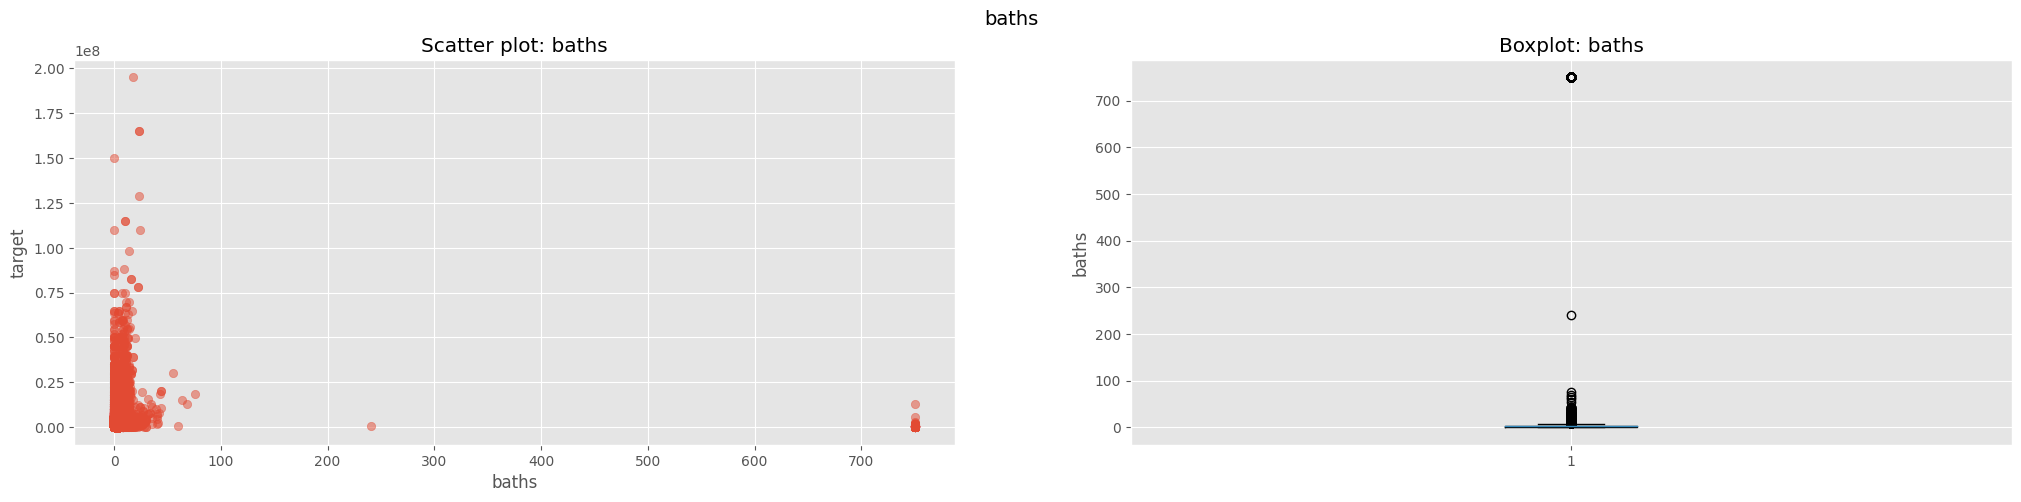

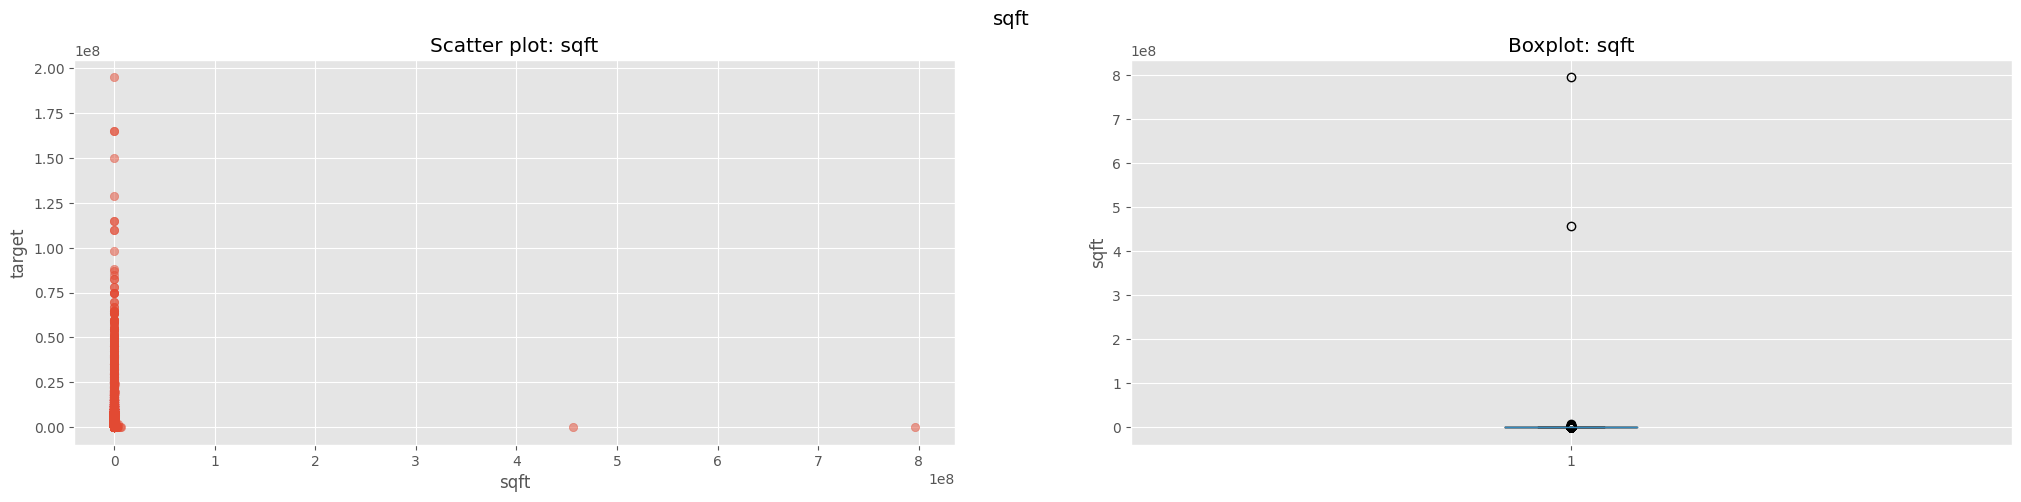

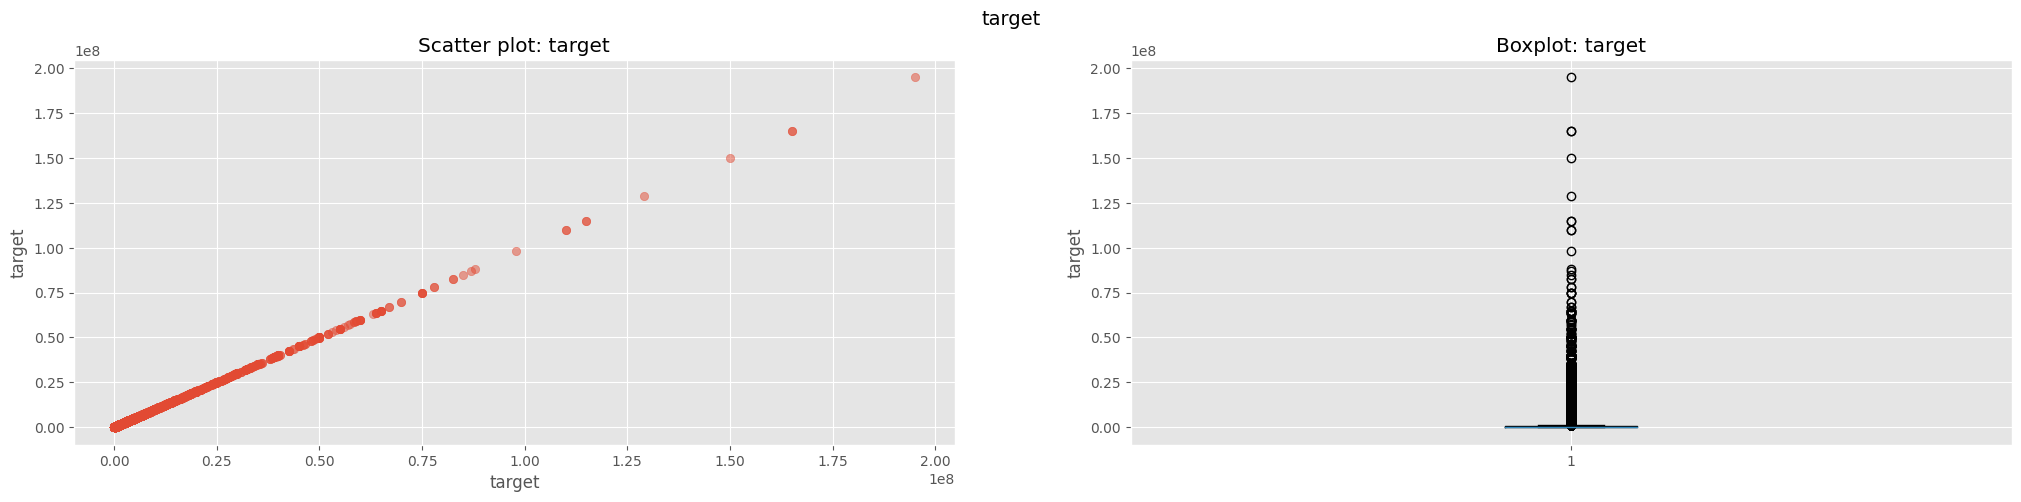

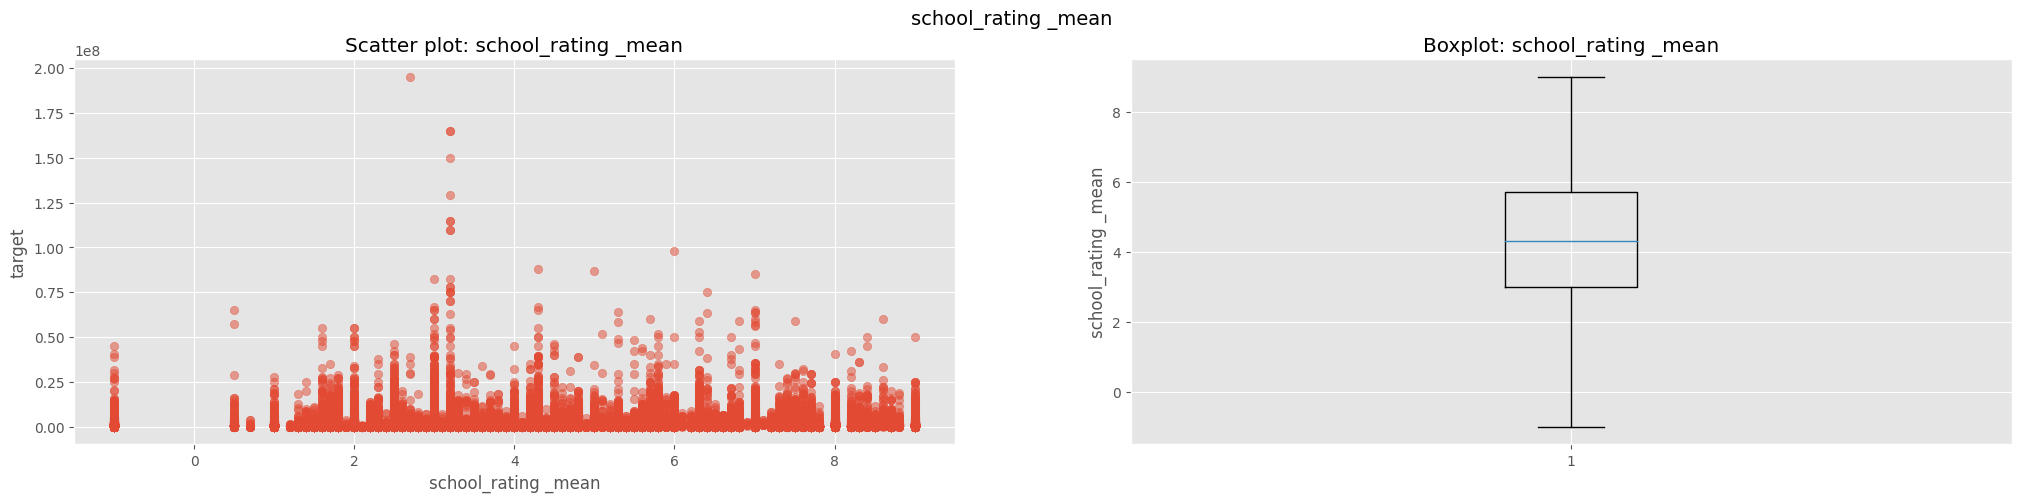

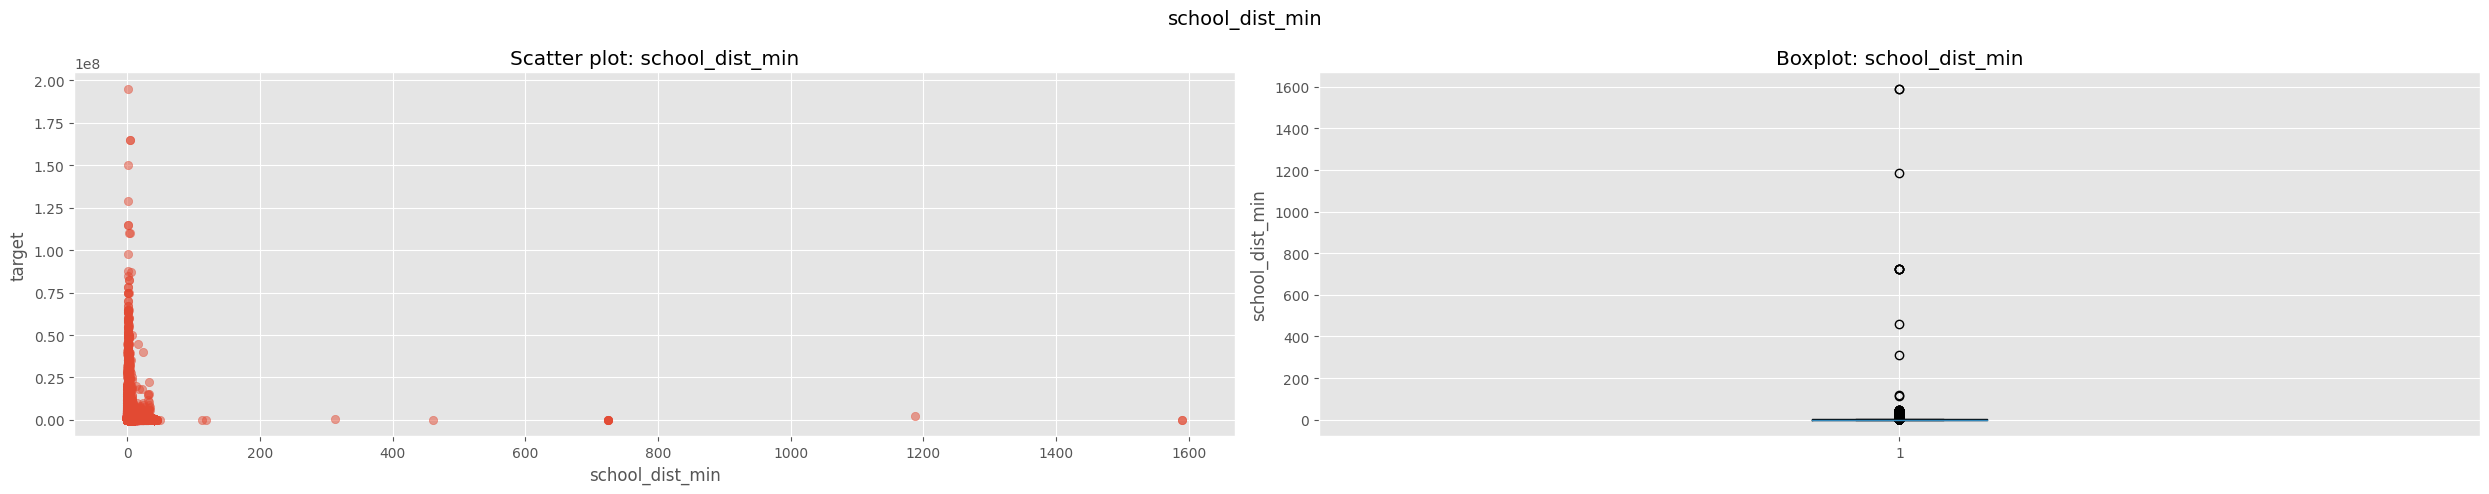

In [124]:
for feature in digital_features:
    fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
    fig.suptitle(f'{feature}', fontsize=14)
      
    barplot.scatter(df[feature], df['target'], alpha=0.5)
    barplot.set_title(f'Scatter plot: {feature}')
    barplot.set_xlabel(feature)
    barplot.set_ylabel('target')
    
    boxploot.boxplot(df[feature])
    boxploot.set_title(f'Boxplot: {feature}')
    boxploot.set_ylabel(feature)
    
plt.tight_layout()

Наблюдаются выбросы по признакам: **baths**, **sqft**, **school_dist_min** обработаем эти признаки:

#### 4.1.1 Признак baths

Посмотрим на значения признака выходящих за 100:

In [125]:
d_100 = len(df[df['baths']>100])
d_700 = len(df[df['baths']>700])
print(f"Количество ванных комнат более 100:{d_100}")
print(f"Количество ванных комнат более 700:{d_700}")

Количество ванных комнат более 100:238
Количество ванных комнат более 700:237


Крайне маловероятно, что объект с более чем 700 ванными комнатами стоит менее 1 млн. Посмотри на все объекты в данной выборке, соотнесем с площадью:

In [126]:
df_700_min = (df['baths']>700) & (df['target'] < 1000000)
filtered_df = df[df_700_min]
display(filtered_df)
print(f"Средняя площадь объектов с более чем 700 ванными комнатами и стоимостью до 1 млн.:{round(filtered_df['sqft'].mean())} sqft")
print(f"Наибольшая площадь объектов с более чем 700 ванными комнатами и стоимостью до 1 млн.:{round(filtered_df['sqft'].max())} sqft")

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
1093,auction,other,3624 douglas ave,750.0,True,dallas,1758,75219,TX,False,499000,1993,False,True,False,2.6,0.9
3558,auction,other,601 w 11th ave #409,750.0,False,denver,873,80204,CO,False,348900,1981,True,True,False,4.0,0.2
7487,auction,other,1260 xavier st,750.0,False,denver,1864,80204,CO,False,560000,1936,True,False,False,2.0,0.5
7614,auction,condo,3314 douglas ave unit 202d,750.0,True,dallas,1336,75219,TX,False,285000,1984,False,True,False,2.0,1.0
9715,auction,other,927 meade st,750.0,False,denver,906,80204,CO,False,395000,1954,True,True,False,2.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369214,auction,other,601 pennsylvania ave nw #212,750.0,False,washington,801,20004,DC,False,449000,1991,False,False,False,6.0,0.2
372211,auction,condo,3225 turtle creek blvd #1646,750.0,False,dallas,832,75219,TX,False,219500,1998,False,True,False,2.6,0.6
372587,auction,condo,2262 alterbrook ln,750.0,False,dallas,2102,75219,TX,False,464900,2019,False,True,False,2.0,0.1
372722,auction,condo,3225 turtle creek blvd #528,750.0,False,dallas,837,75219,TX,False,240000,1998,False,True,False,2.6,0.6


Средняя площадь объектов с более чем 700 ванными комнатами и стоимостью до 1 млн.:1409 sqft
Наибольшая площадь объектов с более чем 700 ванными комнатами и стоимостью до 1 млн.:3707 sqft


Видим, что 213 объектов имеют более 700 ванных комнат на незначительной площади и стоят не соизмеримо. Удалим их:

In [127]:
df.drop(df[df_700_min].index, inplace=True)

Посмотрим на объекты с колличеством ванных комнат больше 100:

In [128]:
df_100 = (df['baths']>100)
filtered_df = df[df_100]
display(filtered_df)
print(f"Средняя площадь объектов с более чем 100 ванными комнатами:{round(filtered_df['sqft'].mean())} sqft")
print(f"Наибольшая площадь объектов с более чем 100 ванными комнатами:{round(filtered_df['sqft'].max())} sqft")

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
1997,auction,other,920 i st nw #411,750.0,False,washington,1367,20001,DC,False,1499000,2013,False,False,False,6.8,0.3
11015,for sale,single_family_home,1204 e helena ave,241.0,False,mcallen,3770,78503,TX,False,449000,2014,True,True,True,5.0,2.6
20835,auction,modern,1575 n king st,750.0,True,denver,3375,80204,CO,False,1199900,2019,True,True,False,2.0,0.1
20956,auction,other,4200 w 17th ave #335,750.0,False,denver,1444,80204,CO,False,1032000,2019,True,True,False,2.0,0.3
24614,auction,other,4020 rawlins,750.0,False,dallas,9800,75219,TX,False,1985000,1963,False,True,False,2.0,0.8
47244,auction,condo,2828 hood st #1403,750.0,True,dallas,3990,75219,TX,False,1595000,2000,False,True,False,2.6,0.9
52994,auction,modern,701 pennsylvania ave nw unit 1025-1026,750.0,False,washington,1775,20004,DC,False,1595000,1991,False,False,False,6.3,0.1
81342,auction,other,3535 gillespie st #604,750.0,True,dallas,2899,75219,TX,False,1175000,2000,False,True,False,2.6,0.8
83077,auction,other,60 w 10th ave,750.0,True,denver,2440,80204,CO,False,1150000,2019,True,True,False,4.0,0.4
83151,auction,single_family_home,2908 hood st,750.0,True,dallas,6547,75219,TX,False,2295000,2003,False,True,False,2.6,0.8


Средняя площадь объектов с более чем 100 ванными комнатами:4091 sqft
Наибольшая площадь объектов с более чем 100 ванными комнатами:26200 sqft


Проверка по средствам интернет-поиска показала, что даже объекты с большой площадью не имеют по 750 ванных комнат. Удалим их:

In [129]:
df.drop(df[df_100].index, inplace=True)

Посмотрим на признак после удаления выбрасов:

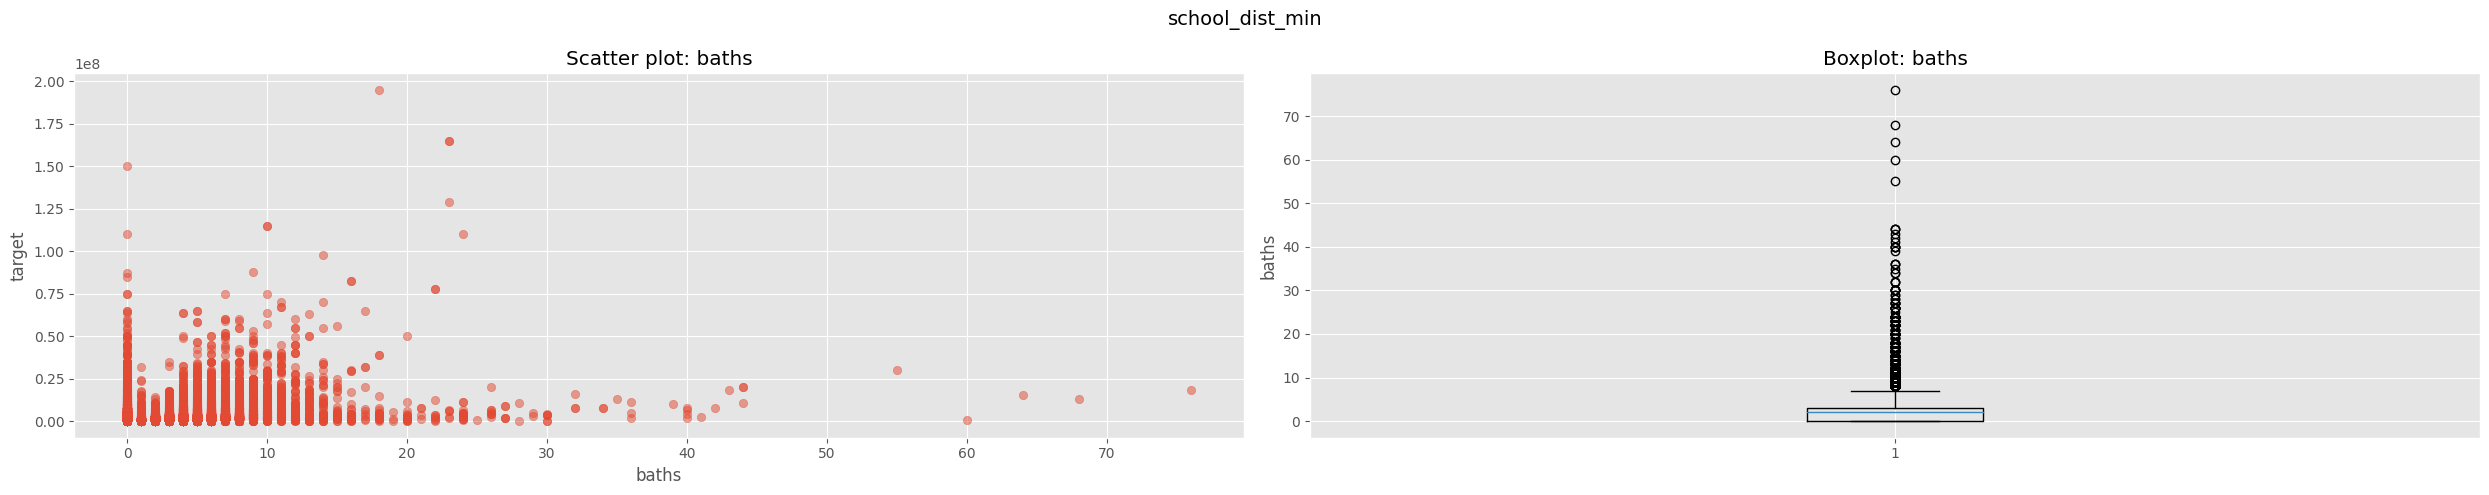

In [130]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['baths'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: baths')
barplot.set_xlabel('baths')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['baths'])
boxploot.set_title(f'Boxplot: baths')
boxploot.set_ylabel('baths')
    
plt.tight_layout()

У нас есть небольшое количество объектов с более чем 30ю ванными комнатами, проверим их:

In [131]:
df_30 = (df['baths']>30)
filtered_df = df[df_30]
display(filtered_df)
print(f"Средняя площадь объектов с более чем 30 ванными комнатами:{round(filtered_df['sqft'].mean())} sqft")
print(f"Наибольшая площадь объектов с более чем 30 ванными комнатами:{round(filtered_df['sqft'].max())} sqft")

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
21297,for sale,multi_family_home,2900 nw 55th ave,40.0,False,lauderhill,1100,33313,FL,True,1704000,1974,True,True,True,2.8,0.51
33247,auction,multi_family_home,443 s wilton pl,32.0,False,los angeles,19384,90020,CA,False,7580000,1957,True,True,False,6.5,0.30
51210,pending,multi_family_home,1522 s orange grove ave,35.0,False,los angeles,24307,90019,CA,False,13000000,2019,True,True,False,5.2,0.40
68882,Under Contract,multi_family_home,1336 and 1340 sheridan blvd,40.0,False,denver,16506,80214,CO,False,4500000,2019,True,True,True,2.5,0.10
79462,for sale,multi_family_home,21411 35th ave #101,76.0,False,bayside,31000,11361,NY,False,18500000,2016,False,True,False,3.8,0.07
86057,for sale,multi_family_home,443 s wilton pl,32.0,False,los angeles,19384,90020,CA,False,7580000,1957,True,False,True,6.7,1.23
97360,for sale,multi_family_home,21411 35th ave,43.0,False,flushing,22600,11361,NY,False,18500000,2019,True,False,True,3.8,0.07
99886,for sale,multi_family_home,101 harrison st,34.0,False,denver,17672,80206,CO,False,7900000,2015,True,True,True,6.3,0.43
109509,for sale,multi_family_home,77 park dr # 81,55.0,False,boston,30500,02215,MA,False,30000000,1910,False,False,False,2.5,0.20
121022,for sale,multi_family_home,40 parker hill ave #44,44.0,False,boston,21210,2120,MA,False,20000000,1910,False,False,False,-1.0,-1.00


Средняя площадь объектов с более чем 30 ванными комнатами:22469 sqft
Наибольшая площадь объектов с более чем 30 ванными комнатами:39514 sqft


Соотношение стоимость, площать, количество ванных комнат - адекватно. Ручная проверка выборочных объектов показала соответствие данных. Пока оставим их.

#### 4.1.2 Признак sqft

Посмотрим на выбросы в параметре **sqft**:

In [132]:
outliers = ((df['sqft'] < 100)  | (df['sqft'] > 455000000))
filtered1_df = df[outliers]

filtered1_df.shape[0]

52652

Удалим явные выбросы:

In [133]:
df.drop(df[outliers].index, inplace=True)

Посмотрим на оставшиеся выбросы:

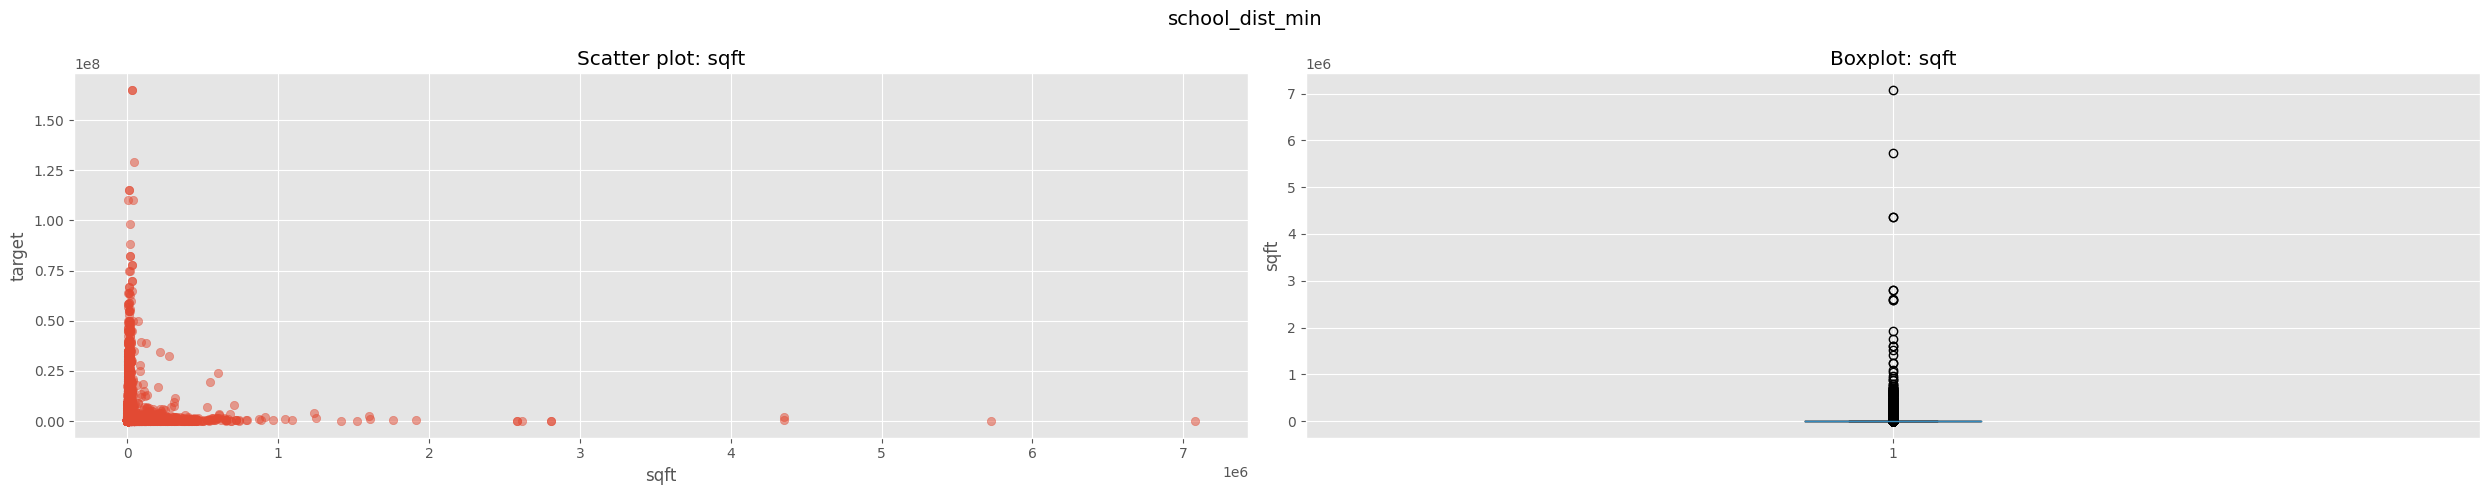

In [134]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['sqft'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: sqft')
barplot.set_xlabel('sqft')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['sqft'])
boxploot.set_title(f'Boxplot: sqft')
boxploot.set_ylabel('sqft')
    
plt.tight_layout()

Проверим объекты с площадью более 30000:

In [135]:
df_30k = df[df['sqft']>30000]
df_30k.head(17)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,PrivatePool,target,Year built,Heating,Cooling,Parking,school_rating _mean,school_dist_min
89,for sale,condo,8470 129th st #4a,2.0,False,kew gardens,107250,11415,NY,False,319000,1969,False,False,False,5.3,0.37
133,for sale,single_family_home,20910 41st ave #3c,0.0,False,bayside,109200,11361,NY,False,270000,1963,True,False,False,3.8,0.51
197,for sale,condo,345 w 145th st #2c2,0.0,False,new york,225667,10031,NY,False,455000,1957,False,False,False,1.7,0.48
309,for sale,condo,21015 23rd ave #6b,0.0,False,bayside,373772,11360,NY,False,239000,1961,True,False,True,7.7,0.27
386,for sale,condo,6837 108th st #4f,0.0,False,forest hills,71838,11375,NY,False,440000,1939,False,False,False,3.5,0.26
562,for sale,condo,975 park ave #14b,4.0,True,new york,142075,10028,NY,False,5300000,1929,False,True,False,4.3,0.12
718,for sale,condo,3815 149th st #1l,0.0,False,flushing,114151,11354,NY,False,295000,1955,False,False,False,5.3,0.28
1703,auction,other,0 judson rd,0.0,False,san antonio,119921,78247,TX,False,89480,no info,False,False,False,6.0,0.30
2022,foreclosure,condo,240 e 55th st #8e,0.0,False,new york,32767,10022,NY,False,1282697,1963,False,False,False,5.8,0.09
2211,for sale,condo,233 e 69th st #10i,0.0,False,new york,206511,10021,NY,False,699000,1957,False,False,False,4.3,0.32


Видим, что это в основном квартиры с указаной площадью комплекса. Удалим их:

In [136]:
fo_del = (df['sqft']>30000)
df.drop(df[fo_del].index, inplace=True)

Посмотрим на признак после удаления выбросов:

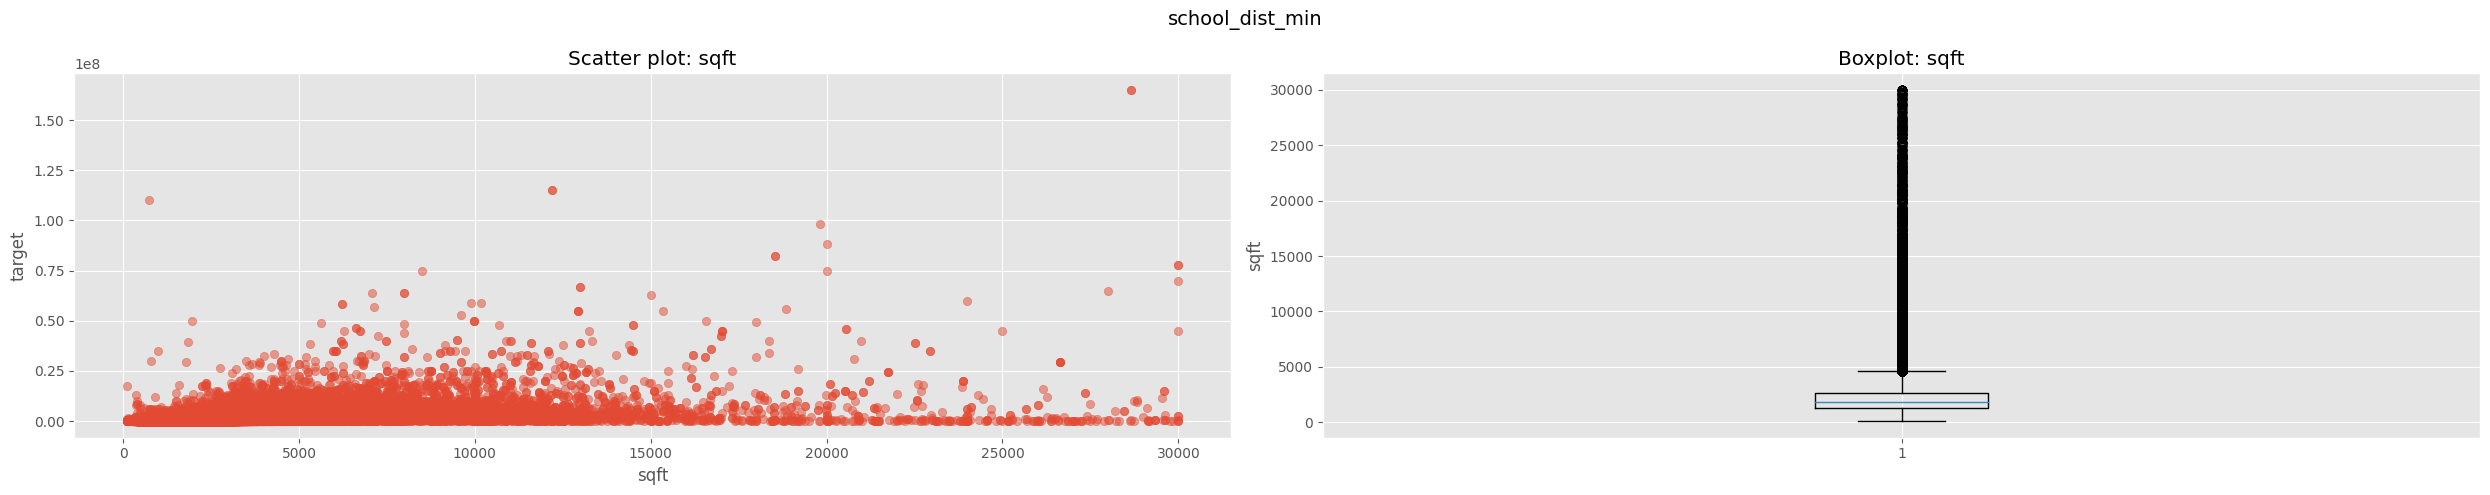

In [137]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['sqft'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: sqft')
barplot.set_xlabel('sqft')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['sqft'])
boxploot.set_title(f'Boxplot: sqft')
boxploot.set_ylabel('sqft')
    
plt.tight_layout()

Результат представляется удовлетворительным, пока оставим так.

#### 4.1.3 Признак school_dist_min

Посмотрим на количество объектов с минимальным растоянием до школы более 30:

In [138]:
outliers = (df['school_dist_min'] > 30)
filtered_df = df[outliers]
filtered_df.shape[0]

293

Таких объектов всего 10. Удалим их:

In [139]:
df.drop(df[outliers].index, inplace=True)

Посмотрим на признак после удаления выбросов:

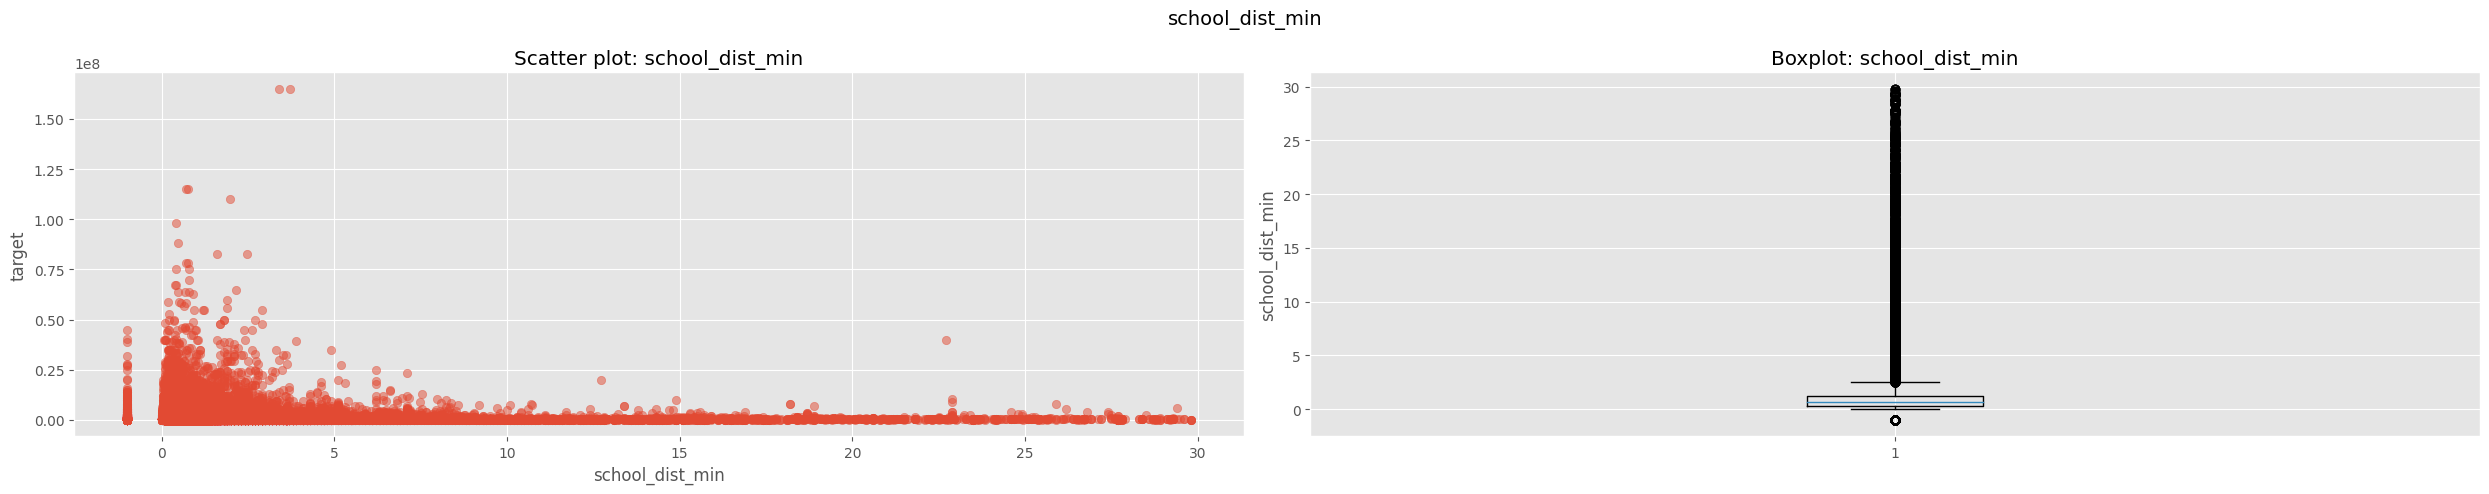

In [140]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['school_dist_min'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: school_dist_min')
barplot.set_xlabel('school_dist_min')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['school_dist_min'])
boxploot.set_title(f'Boxplot: school_dist_min')
boxploot.set_ylabel('school_dist_min')
    
plt.tight_layout()

Признак распределен равномернее, пока оставим так.

#### 4.1.4 Признак target

Посмотрим на выбросы в признаке: 

In [141]:
outliners = (df['target'] > 2000000)
filtered_df = df[outliners]

print(len(filtered_df))

13680


Незначительное количество объектов со стоимостью более 2млн. может оказывать значительное влияние на результат предсказания. Удалим их, что бы сделать признак равномернее:

In [142]:
df.drop(df[outliners].index, inplace=True)

Посмотрим на распределение призака после удаления выбросов:

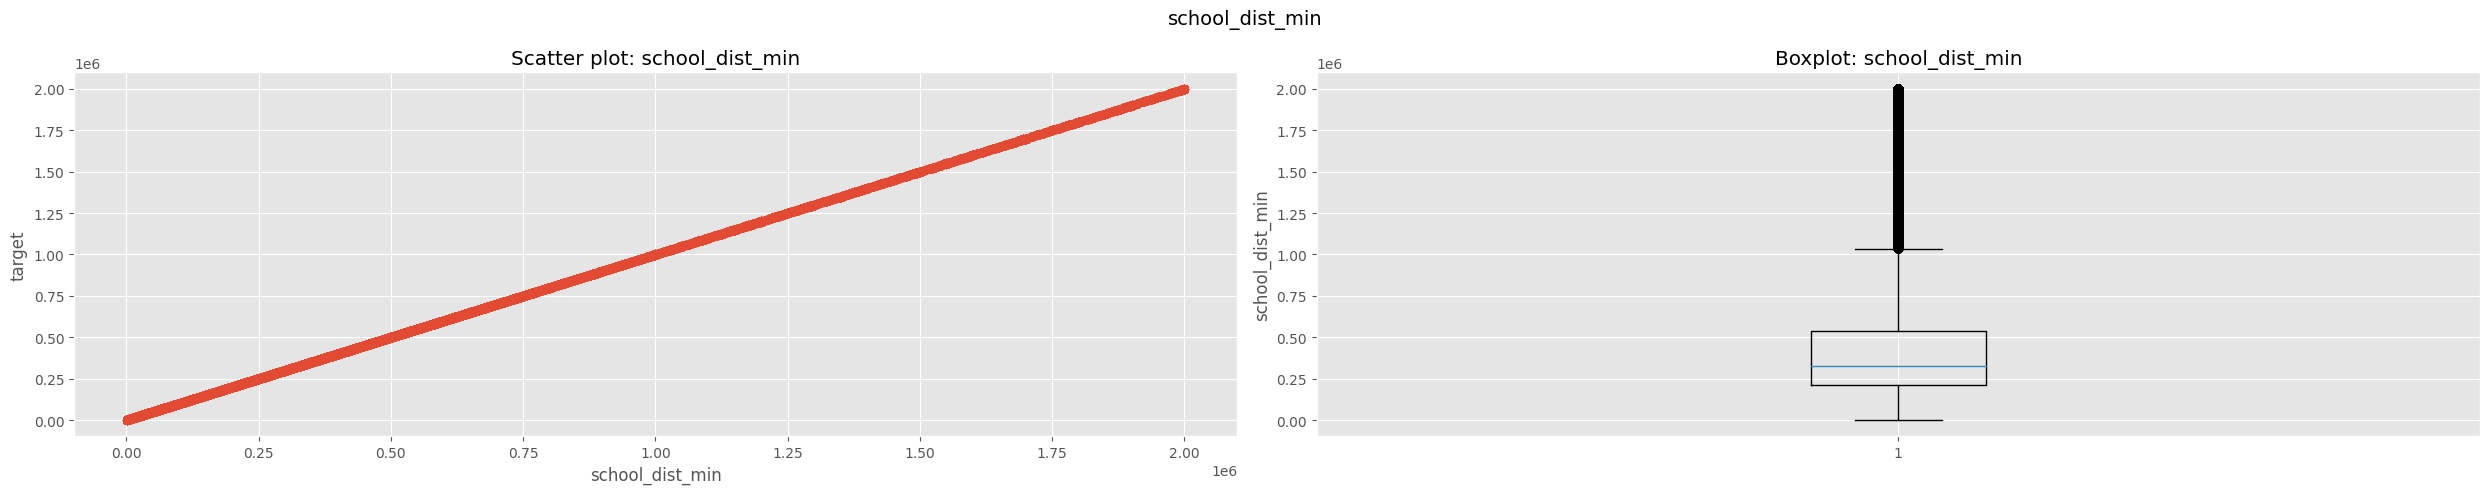

In [143]:
fig, (barplot,boxploot) = plt.subplots(1, 2, figsize=(25, 5)) 
fig.suptitle(f'{feature}', fontsize=14)
      
barplot.scatter(df['target'], df['target'], alpha=0.5)
barplot.set_title(f'Scatter plot: school_dist_min')
barplot.set_xlabel('school_dist_min')
barplot.set_ylabel('target')
    
boxploot.boxplot(df['target'])
boxploot.set_title(f'Boxplot: school_dist_min')
boxploot.set_ylabel('school_dist_min')
    
plt.tight_layout()

На настоящий момент нас удовлетворит такой результат.

### 4.2.НОРМАЛИЗАЦИЯ 

Посмотрим на линейную регрессию числовых признаков:

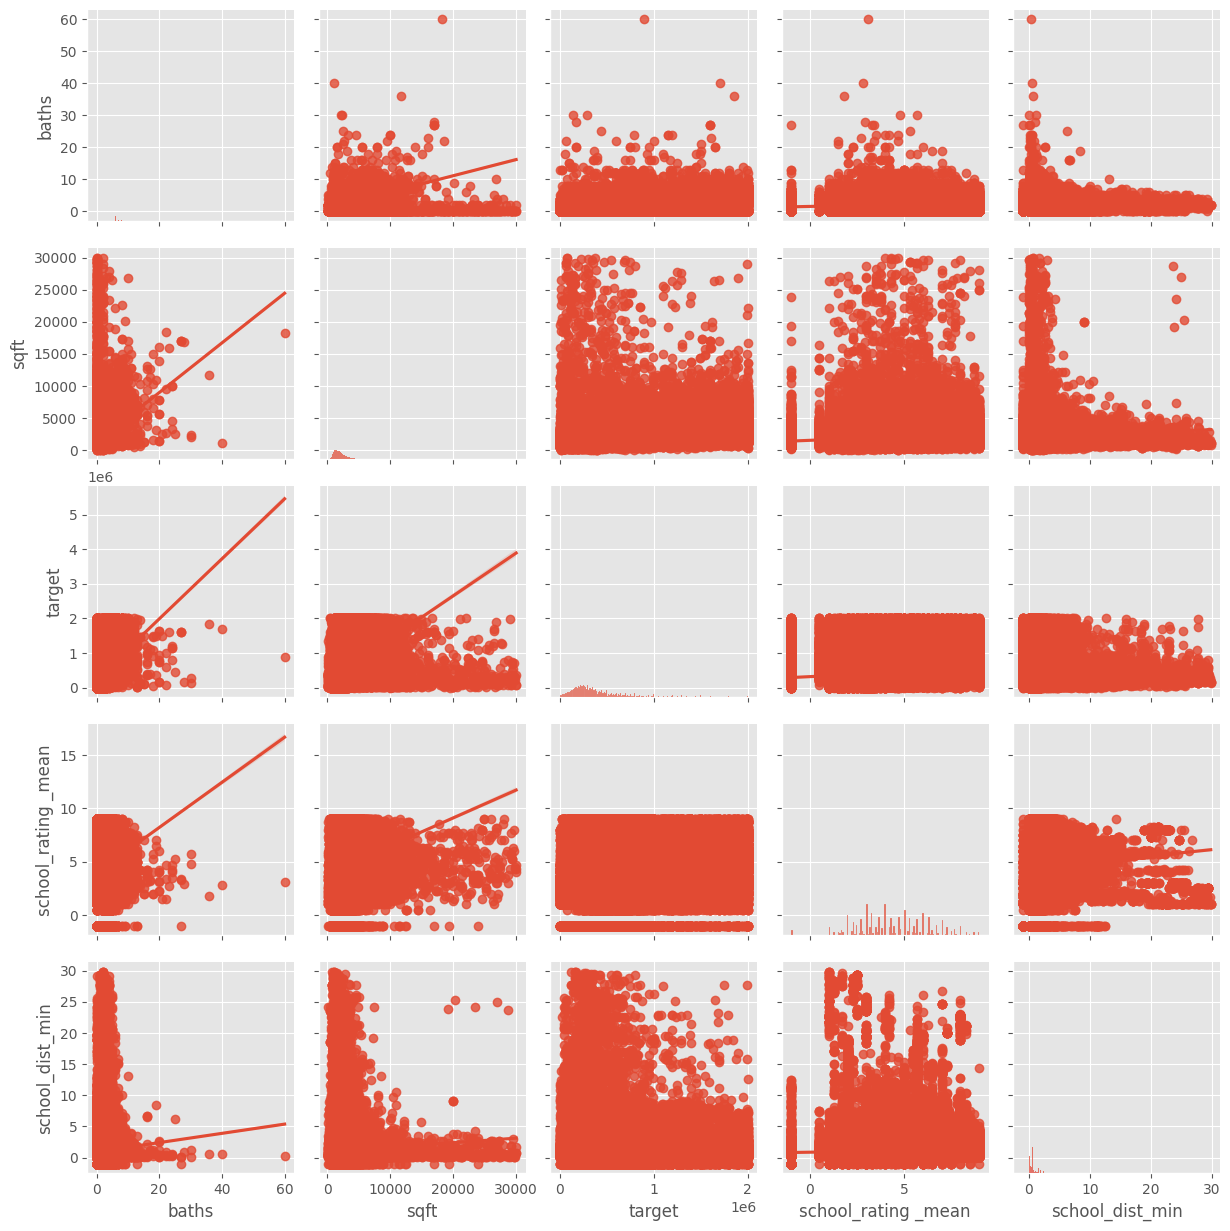

In [144]:
data_selected = df[digital_features]

sns.pairplot(data_selected, kind='reg')
plt.savefig('images/plot.png', format='png')

plt.show()

Посмотрим на нормальность числовых признаков:

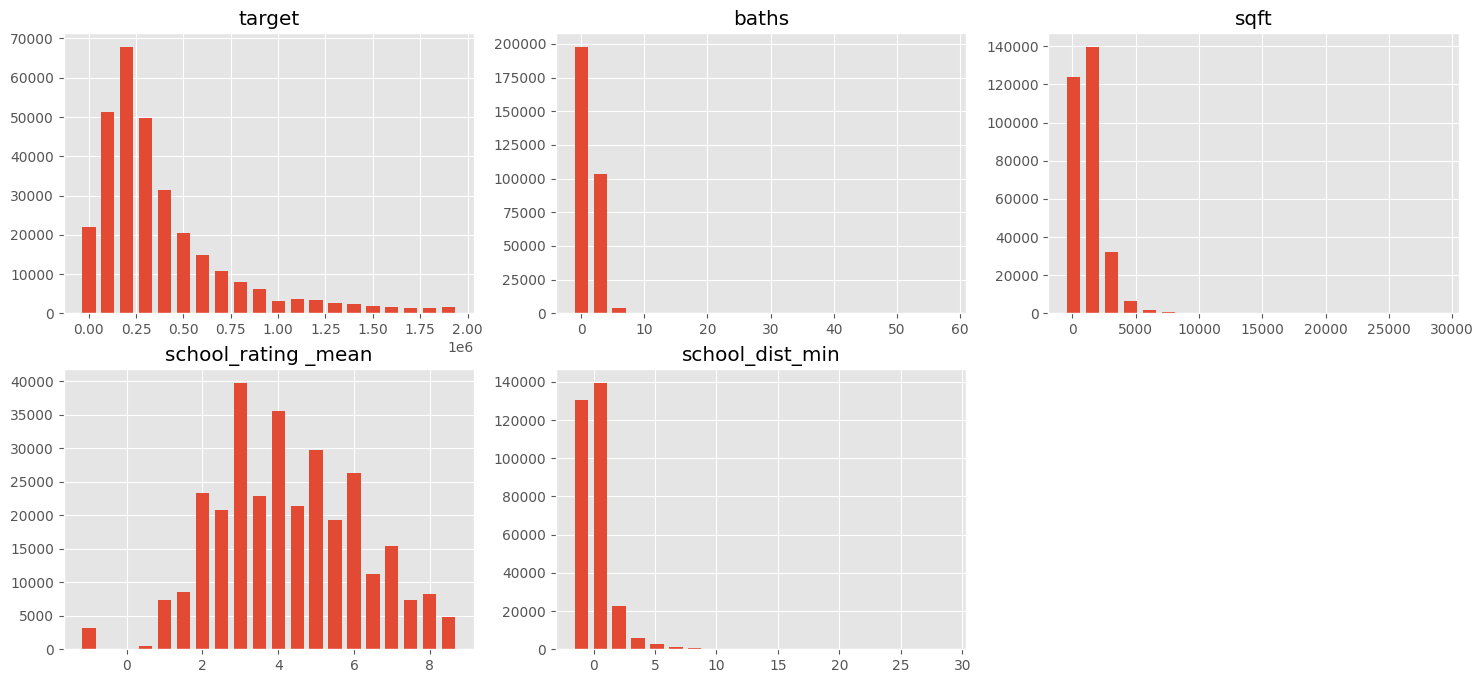

In [145]:
def visnormaldistrib(values):
  columns = min(3, len(values))
  rows = (len(values) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(values.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()
  
visnormaldistrib({'target': df['target'], 'baths': df['baths'],'sqft': df['sqft'],'school_rating _mean': df['school_rating _mean'],'school_dist_min': df['school_dist_min'],})

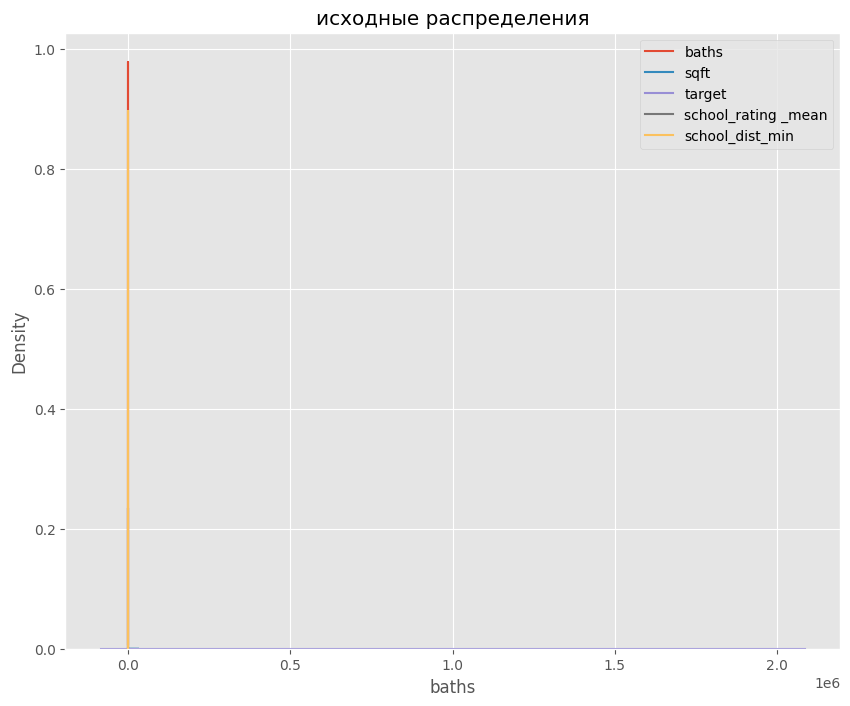

In [146]:
filtered_df = df[digital_features]

col_names = list(filtered_df.columns)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('исходные распределения')


sns.kdeplot(filtered_df['baths'], ax=ax1, label='baths')
sns.kdeplot(filtered_df['sqft'], ax=ax1, label='sqft')
sns.kdeplot(filtered_df['target'], ax=ax1, label='target')
sns.kdeplot(filtered_df['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(filtered_df['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

Попробуем нормализовать MinMaxScaler'ром:

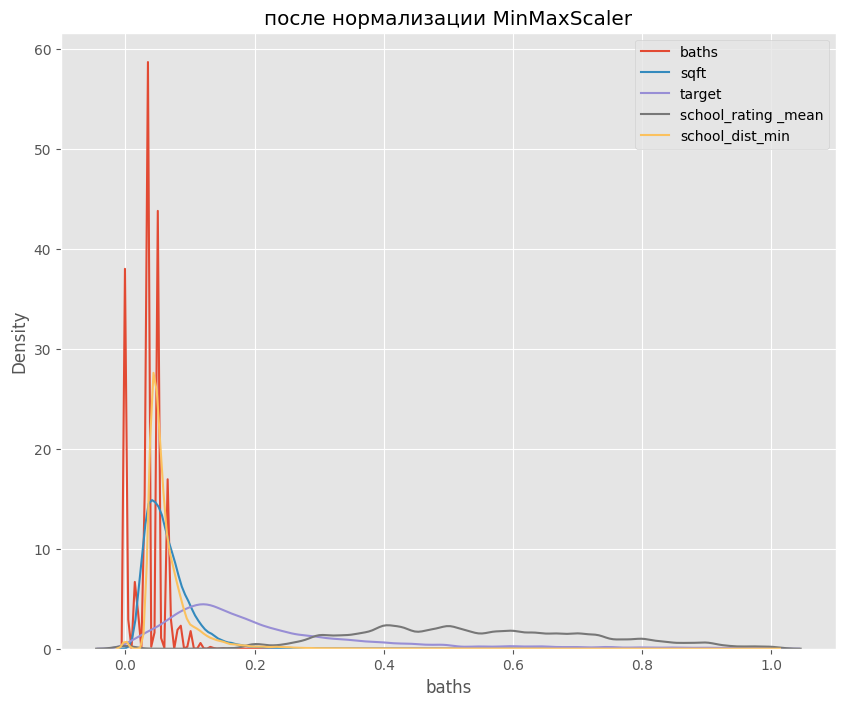

In [147]:
filtered_df = df[digital_features]

col_names = list(filtered_df.columns)

mm_scaler = MinMaxScaler()

df_mm = mm_scaler.fit_transform(filtered_df)

df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации MinMaxScaler')


sns.kdeplot(df_mm['baths'], ax=ax1, label='baths')
sns.kdeplot(df_mm['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_mm['target'], ax=ax1, label='target')
sns.kdeplot(df_mm['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(df_mm['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

Попробуем нормализовать RobustScaler'ром:

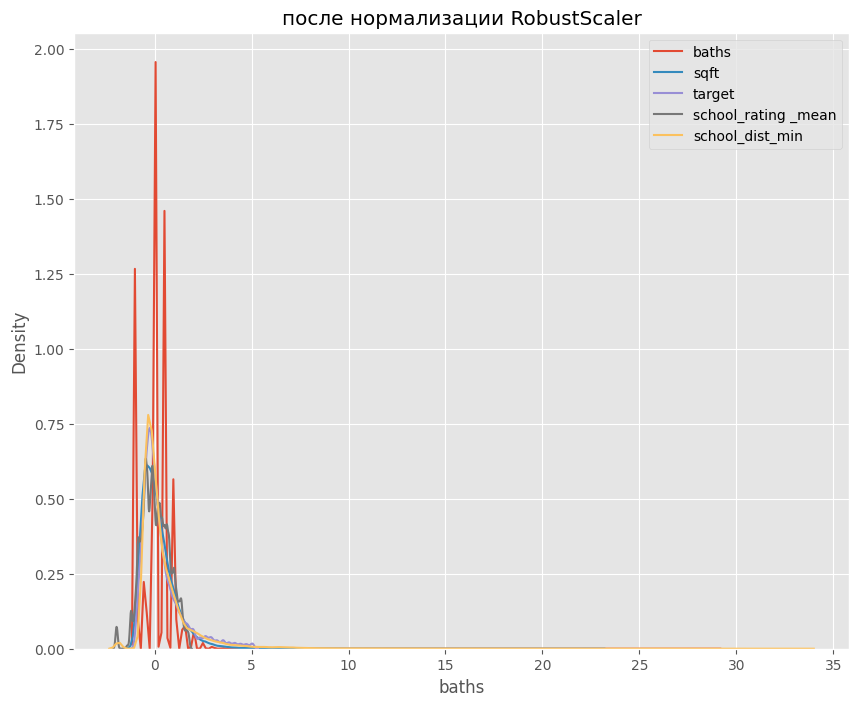

In [148]:
r_scaler = RobustScaler()

df_r = r_scaler.fit_transform(filtered_df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации RobustScaler')


sns.kdeplot(df_r['baths'], ax=ax1, label='baths')
sns.kdeplot(df_r['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_r['target'], ax=ax1, label='target')
sns.kdeplot(df_r['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(df_r['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

RobustScaler показывает лучший результат, однако можно попробовать улучший результат удалением некоторые избыточные значения:

In [149]:
sort_1 = ((df['baths'] > 30) | (df['target'] > 1000000)) | (df['school_dist_min']> 30)
sorted_1_df = df[sort_1]
sort_2 = ((df['baths'] < 1) | (df['sqft'] < 1))
sorted_2_df = df[sort_2]

print(len(sorted_1_df))
print(len(sorted_2_df))

22698
59514


Видим большое количество выбросов соответсвующих условиям, удалим их:

In [150]:
df.drop(df[sort_1].index, inplace=True)
df.drop(df[sort_2].index, inplace=True)

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_22960\1305895701.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.drop(df[sort_2].index, inplace=True)


Посмотрим на соотношение медианы и среднего значения признака **'baths'** после удаления выбросов:

In [151]:
bath_m_m = df['baths'].median() - df['baths'].mean()
print(f"Разница между медианой и средним значением признака bath: {round(bath_m_m)}")

Разница между медианой и средним значением признака bath: -1


Посмотрим на работу RobustScaler после дочистки данных:

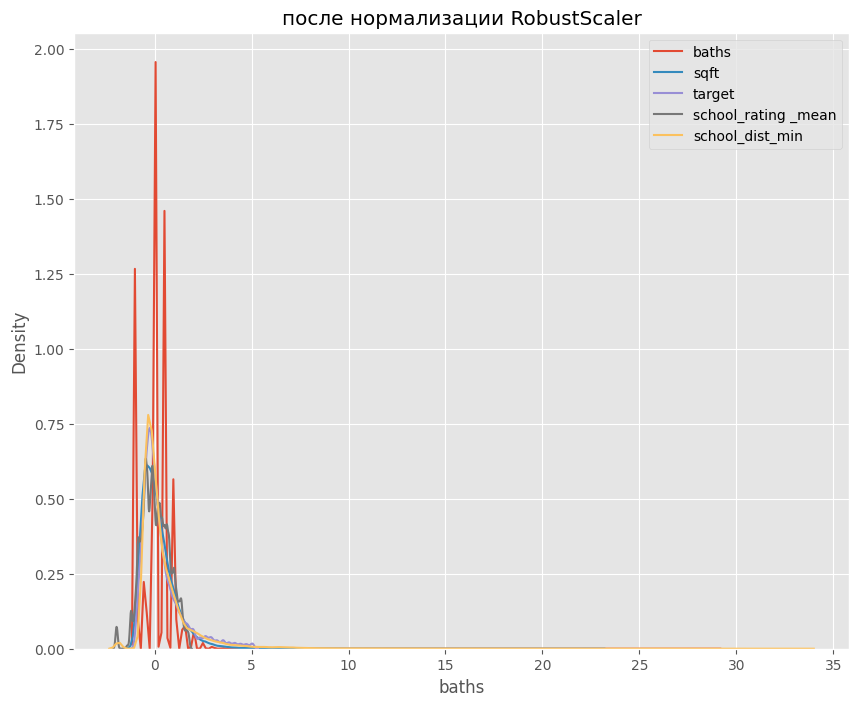

In [152]:
col_names = list(filtered_df.columns)

r_scaler = RobustScaler()

df_r = r_scaler.fit_transform(filtered_df)

df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10,8))

ax1.set_title('после нормализации RobustScaler')


sns.kdeplot(df_r['baths'], ax=ax1, label='baths')
sns.kdeplot(df_r['sqft'], ax=ax1, label='sqft')
sns.kdeplot(df_r['target'], ax=ax1, label='target')
sns.kdeplot(df_r['school_rating _mean'], ax=ax1, label='school_rating _mean')
sns.kdeplot(df_r['school_dist_min'], ax=ax1, label='school_dist_min')
plt.legend()

Результат улучшился, применим RobustScaler к данным:

In [153]:
r_scaler = RobustScaler()
for column in digital_features:
       df[column] = r_scaler.fit_transform(df[[column]])[:,0]


### 4.3.АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

Посмотрим на влияние категориальных признаков на стоимость объекта, напишем функцию выводящую коробки с усами по 10 наиболее значимых значений и их влияние на стоимость объекта, пропустим через нее все категориальные признаки:

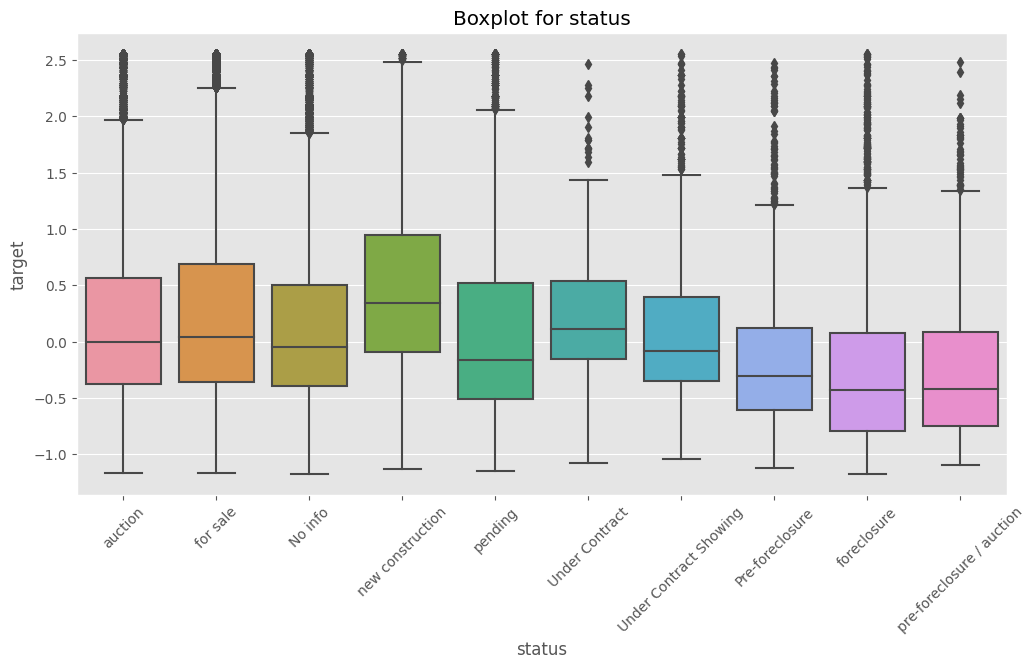

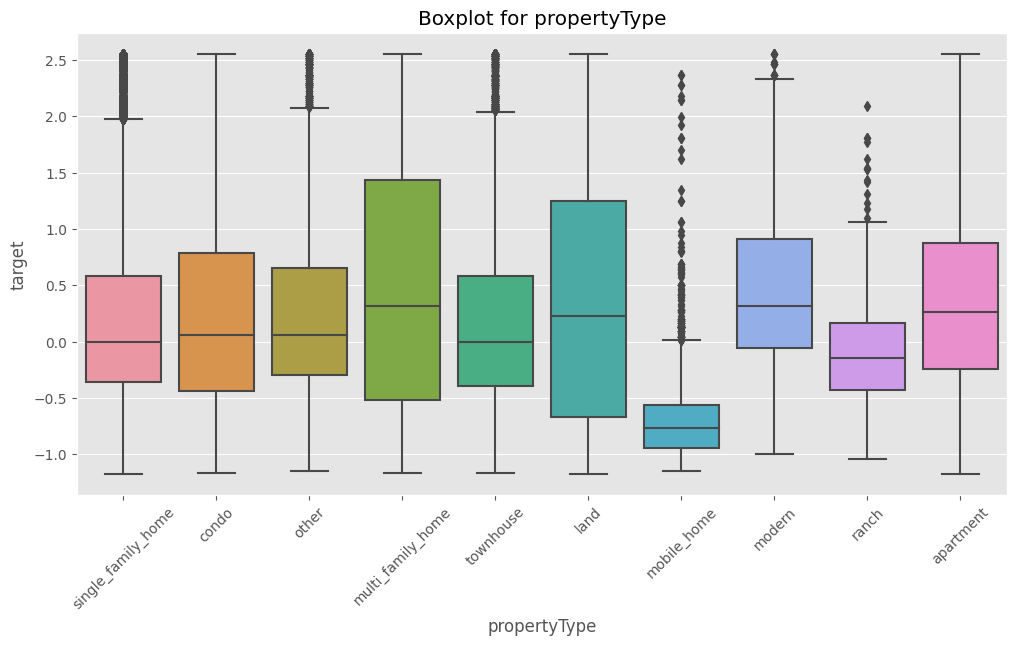

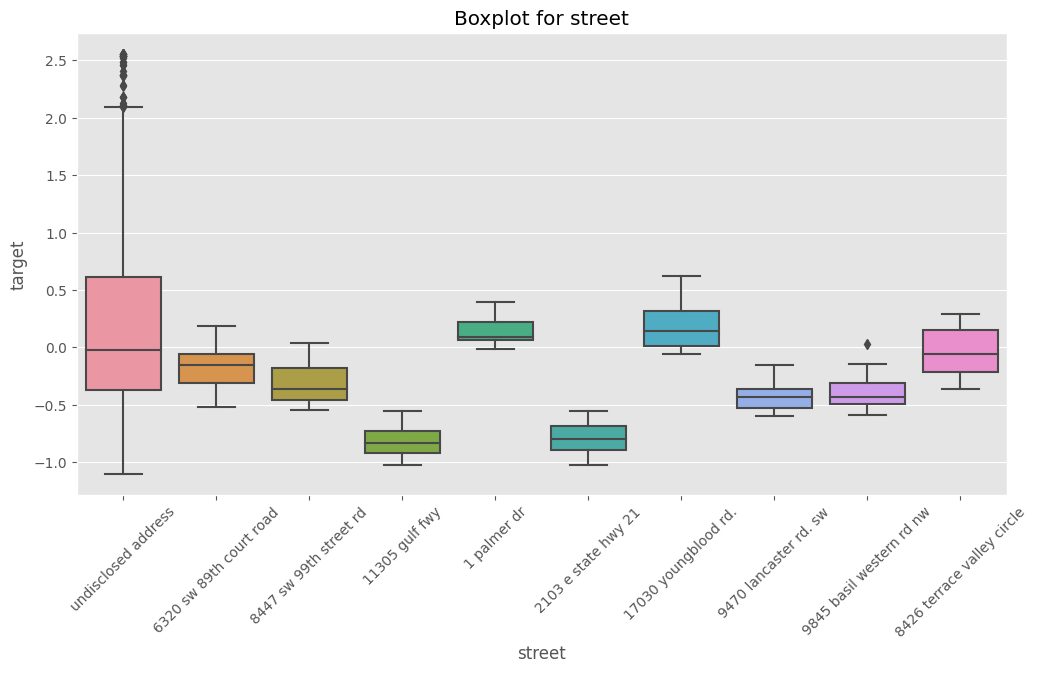

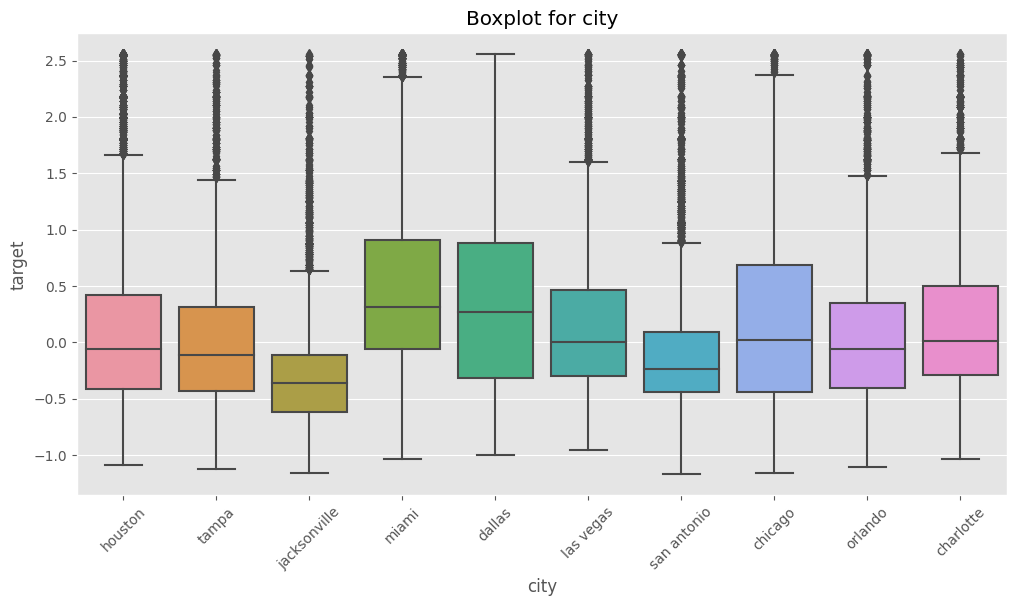

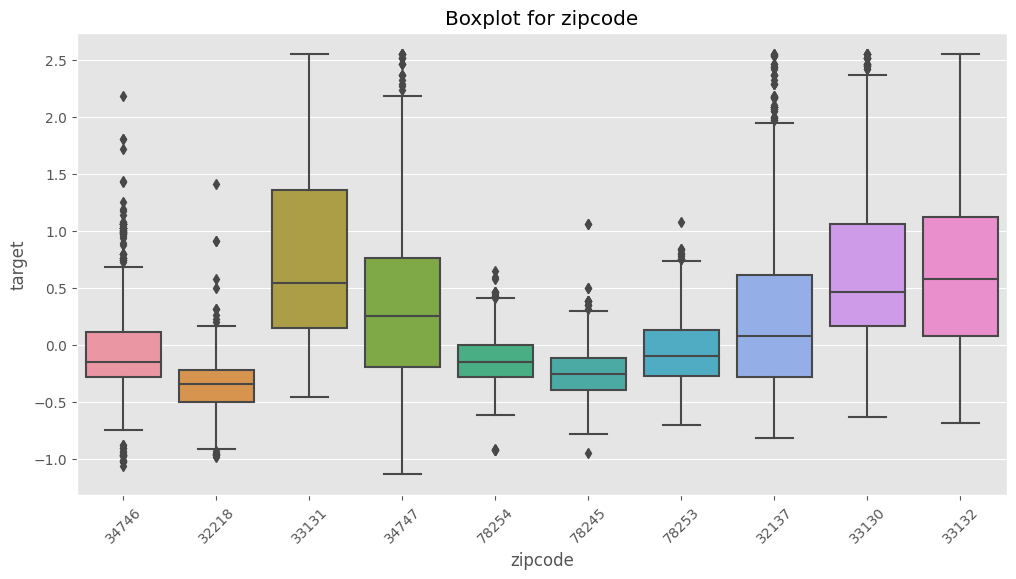

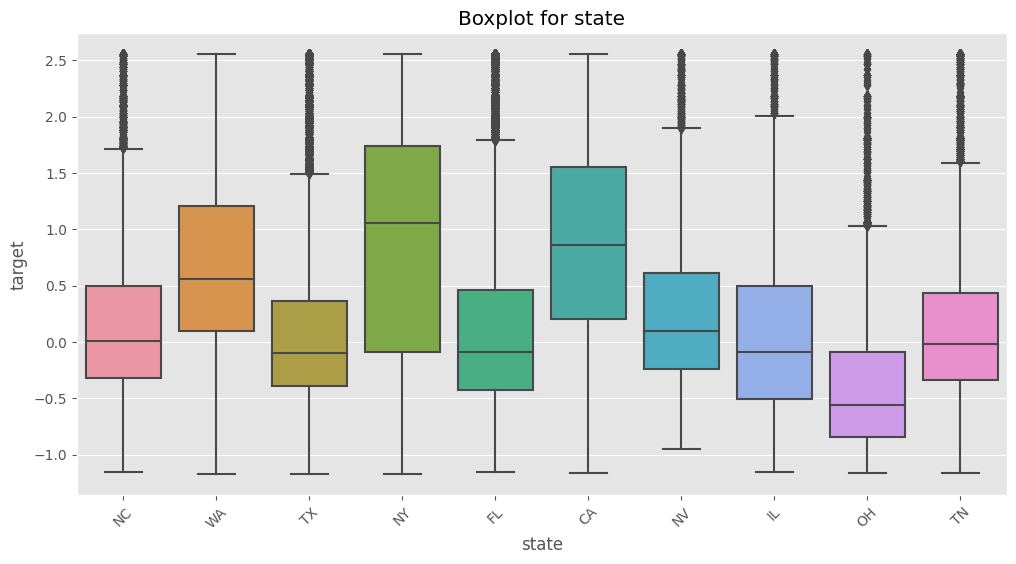

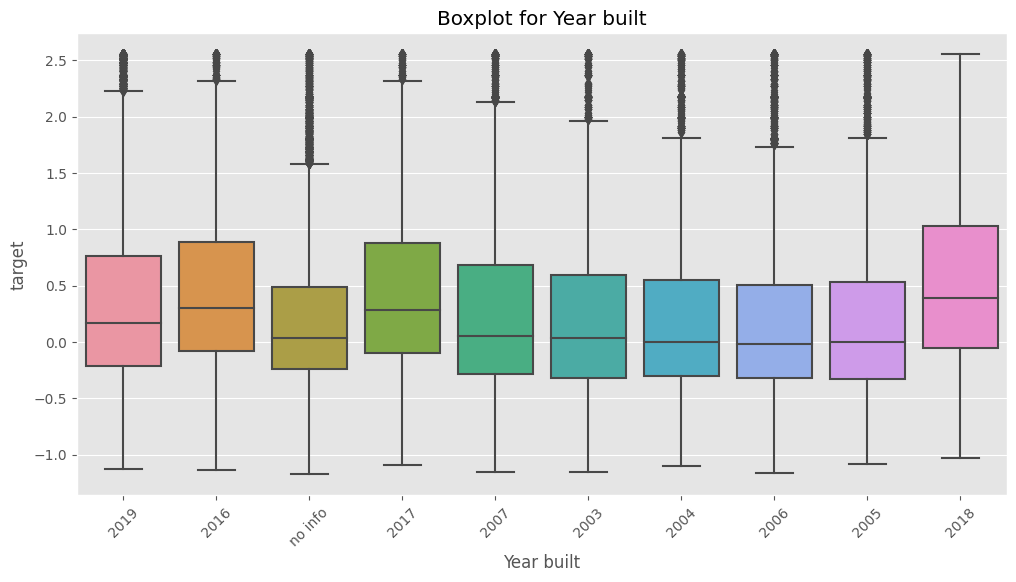

In [154]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (12, 6))
    sns.boxplot(x=column, y='target', 
                data=df.loc[df.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
for col in chain(categorial_features):
    get_boxplot(col)

Посмотрим на количество уникальных значений в категориальных признаках:

In [155]:
for col in categorial_features:
   unique_values = df[col].nunique()
   print(f"Количество уникальных значений в категориальной колонке {col}: {unique_values}")

Количество уникальных значений в категориальной колонке status: 66
Количество уникальных значений в категориальной колонке propertyType: 12
Количество уникальных значений в категориальной колонке street: 198806
Количество уникальных значений в категориальной колонке city: 1571
Количество уникальных значений в категориальной колонке zipcode: 4108
Количество уникальных значений в категориальной колонке state: 34
Количество уникальных значений в категориальной колонке Year built: 207


Видим что признак **street** оказывает наименьшее значение на стоимость при этом имеет наибольшее количество уникальных значений, все это делает его использование при построение модели не рациональным, удалим его:

In [156]:
df = df.drop('street', axis=1)

### 4.4.ВЛИЯНИЯ НОМИНАЛЬНЫХ ПРИЗНАКОВ НА ЦЕЛЕВОЙ ПРИЗНАК

Построим матрицу корреляции для обнаружения линейной связи между целевым признаком и предикторами, а также признаки, которые сильно закоррелированные между собой:

C:\Users\CheshirSmile\AppData\Local\Temp\ipykernel_22960\3827836902.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(round(df.corr(method='spearman'), 2), annot=True)


<AxesSubplot: >

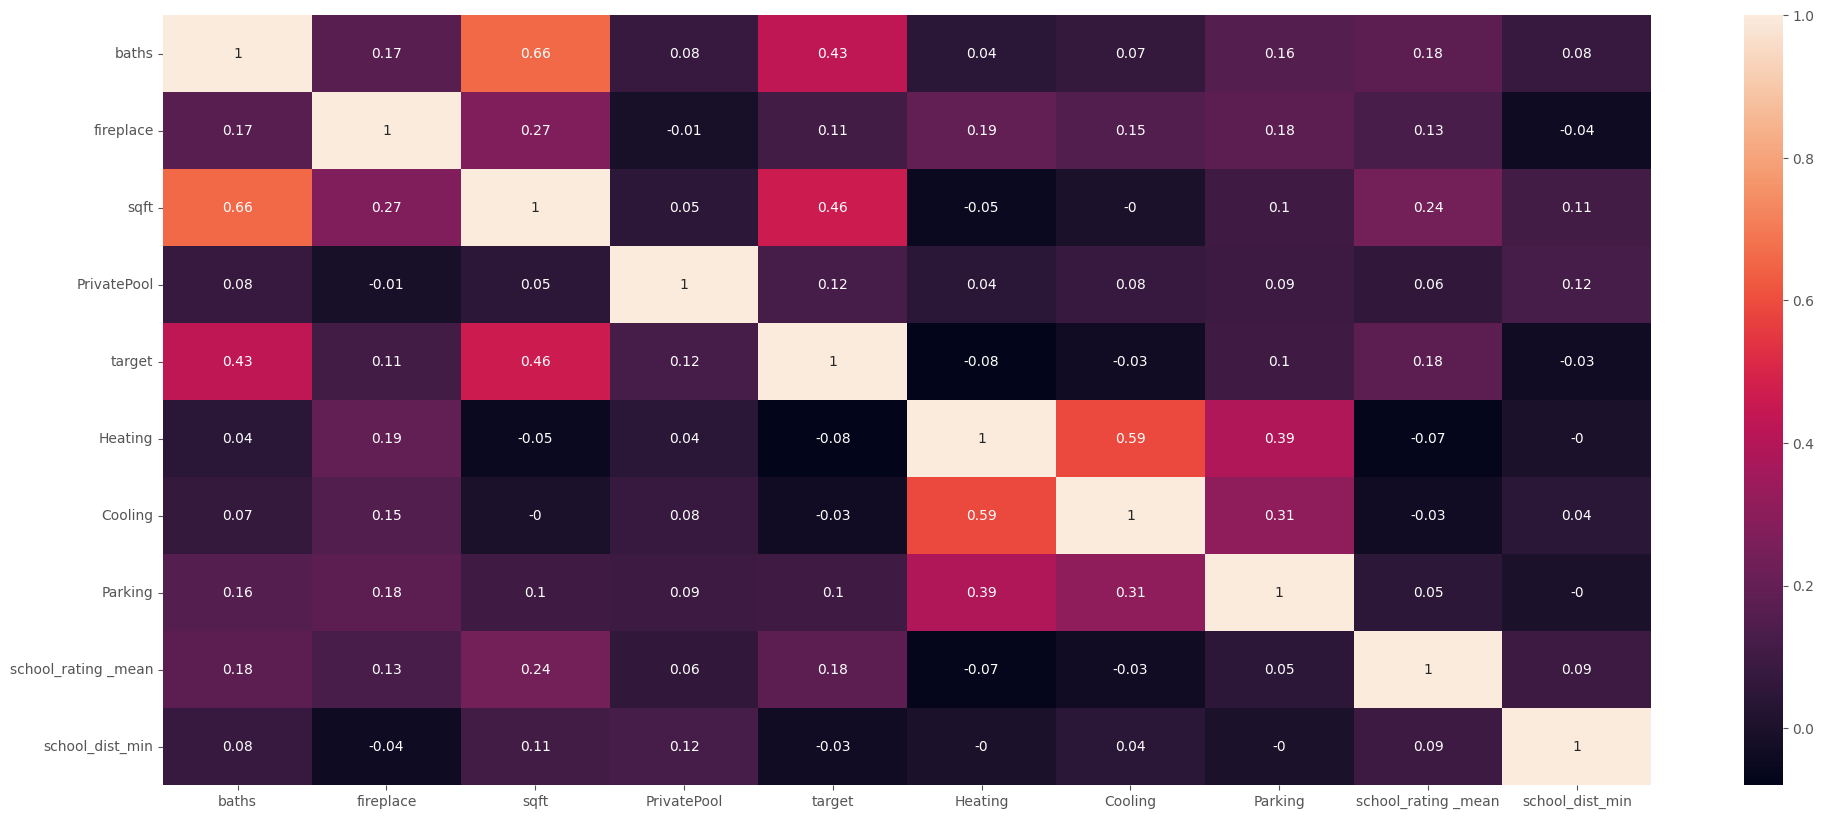

In [157]:
fig, axes = plt.subplots(figsize=(24, 10))
sns.heatmap(round(df.corr(method='spearman'), 2), annot=True)

Коллинеарность не наблюдается. Можно переходить к кодированию признаков.

Сохраним датасет с нормализованными данными:

In [158]:
df.to_csv('data/data_normolized.csv', index=False)

<p> <a href="#TOC">ОГЛАВЛЕНИЕ</a></p>

## 5.КОДИРОВАНИЕ ПРИЗНАКОВ

<p><span id="5"></span></p>

In [159]:
df = pd.read_csv('data/data_normolized.csv')

В дальнейшем мы будем пробовать несколько моделей в том числе *CatBoostRegressor*, не требующий кодирования категориальных признаков, поэтому создадим копию для работы с кодированными признаками: 

In [160]:
df_coded = df.copy()

Признаки **'fireplace', 'PrivatePool', 'Heating', 'Cooling', 'Parking'** содержат только два значения True и False, преобразуем их посредствам *LabelEncoder*:

In [161]:
labelE = LabelEncoder()

for column in binar_features:
    df_coded[column] = labelE.fit_transform(df_coded[[column]])

c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\CheshirSmile\AppData\Local\Programs\Python\Python310\lib\site-packages\sk

Признаки **'propertyType', 'status', 'state', 'city', 'zipcode', 'Year built'** содержат более чем по 15 уникальных значений, что бы не утяжелять датасет избыточными признаками, закодируем их с помощью *BinaryEncoder*, затем удалим исходные столбцы: 

In [162]:
bin_encoder = ce.BinaryEncoder(df_coded['propertyType'])
propertyType_bin = bin_encoder.fit_transform(df_coded['propertyType'])
df_coded = pd.concat([df_coded,propertyType_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_coded['status'])
status_bin = bin_encoder.fit_transform(df_coded['status'])
df_coded = pd.concat([df_coded,status_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_coded['state'])
state_bin = bin_encoder.fit_transform(df_coded['state'])
df_coded = pd.concat([df_coded,state_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_coded['city'])
city_bin = bin_encoder.fit_transform(df_coded['city'])
df_coded = pd.concat([df_coded,city_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_coded['zipcode'])
zipcode_bin = bin_encoder.fit_transform(df_coded['zipcode'])
df_coded = pd.concat([df_coded,zipcode_bin], axis=1)

bin_encoder = ce.BinaryEncoder(df_coded['Year built'])
Yearbuilt_bin = bin_encoder.fit_transform(df_coded['Year built'])
df_coded = pd.concat([df_coded,Yearbuilt_bin], axis=1)


df_coded.drop(['propertyType', 'status', 'state', 'city', 'zipcode', 'Year built'],axis=1,inplace=True)

<p> <a href="#TOC">ОГЛАВЛЕНИЕ</a></p>

## 6.МОДЕЛИРОВАНИЕ

<p><span id="6"></span></p>

Начнем с построения базовой модели результаты которой будем улучшать последующими моделями. Определимся с метриками и разделим выборку на тренировочную и тестовую в соотношении 80/20. Здесь и далее будем обеспечивать воспроизводимость параметром *random_state* = 42.

За базовую модель возьмем модель линейной регрессии с параметрами по умолчанию.  

Метрики:
* $MAE$ (Средняя абсолютная ошибка, Mean Absolute Error) - это мера ошибки, вычисленная как среднее значение абсолютных значений ошибок. Меньшие значения MAE указывают на лучшую точность модели;
* $MSE$ Среднеквадратическая ошибка (Mean Squared Error, MSE) -  квадрат средней ожидаемой разницы между прогнозным значением и фактическим значением;
* ${R^2}$ (коэффициент детерминации) - статистическая мера, которая показывает, насколько хорошо вариации зависимой переменной объясняются моделью.

Разделять выборку методом *train_test_split*.

In [163]:
X = df_coded.drop(['target'], axis=1)
y = df_coded['target']


code_X_train, code_X_test, code_y_train, code_y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

### BASELINE (LinearRegression)

In [164]:
# создаём модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# вычисляем коэффициенты регрессии
model.fit(code_X_train, code_y_train)

# делаем предсказания с помощью модели
base_y_train_pred = model.predict(code_X_train)
base_y_test_pred = model.predict(code_X_test)

Посмотрим на значение метрик применительно к базовой модели(линейная ригрессия с параметрами по умолчанию):

In [166]:
base_mse_train = metrics.mean_squared_error(code_y_train, base_y_train_pred)
base_mse_test = metrics.mean_squared_error(code_y_test, base_y_test_pred)
base_mae_train = metrics.mean_absolute_error(code_y_train, base_y_train_pred)
base_mae_test = metrics.mean_absolute_error(code_y_test, base_y_test_pred)
base_r2_train = metrics.r2_score(code_y_train, base_y_train_pred)
base_r2_test = metrics.r2_score(code_y_test, base_y_test_pred)

base_data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
        'Baseline(LR)': [round(base_mse_train,2), round(base_mse_test,2), round(base_mae_train,2), round(base_mae_test,2), round(base_r2_train,2), round(base_r2_test,2)]}

base = pd.DataFrame(base_data)
base

,Metric,Baseline(LR)
0,Train MSE,0.45
1,Test MSE,0.45
2,Train MAE,0.51
3,Test MAE,0.51
4,Train R^2,0.31
5,Test R^2,0.31


In [ ]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = code_y_train - model.predict(code_X_train)
#Ошибки модели на тестовой выборке
y_test_errors = code_y_test - model.predict(code_X_test)
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

Нельзя сказать, что модель всегда ошибается, но ее результаты далеки от приемлимых. Значение $MSE$ (45), $MAE$ (51) - указывают на невысокую точность модели. ${R^2}$ 31 говорит о том, что модель только в 31% случаев объясняет изменение целевой переменной. Стоит обратить внимание на одинакокую точность как на тренировочной так и на тестовой выборке, что говорит об отсутствие переобучения.

Попробуем улучшить результаты построением модели с полиноминальными признаками:

#### Улучшение линейной регрессии

In [178]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE:', round(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE:', round(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [185]:
from sklearn import feature_selection

selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
selector.fit(code_X_train, code_y_train)
best_features = selector.get_feature_names_out()
best_features

array(['baths', 'fireplace', 'sqft', 'PrivatePool', 'Heating', 'Cooling',
       'Parking', 'school_rating _mean', 'propertyType_3', 'status_3',
       'status_5', 'status_6', 'state_2', 'state_3', 'state_4', 'city_4',
       'city_6', 'city_8', 'city_9', 'city_10', 'zipcode_11',
       'zipcode_12', 'Year built_1', 'Year built_3', 'Year built_4'],
      dtype=object)

In [187]:
model_1 = LinearRegression()
model_1.fit(code_X_train[best_features], code_y_train)
y_train_predict = model_1.predict(code_X_train[best_features])
y_test_predict = model_1.predict(code_X_test[best_features])

print_metrics(code_y_train, y_train_predict, code_y_test, y_test_predict)


Train R^2: 0.298
Train MAE: 1
Train MAPE: 435587723749683


Test R^2: 0.299
Test MAE: 1
Train MAPE: 486928736653897


In [182]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=True)

poly.fit(code_X_train)
X_train_poly = poly.transform(code_X_train)
X_test_poly = poly.transform(code_X_test)

model_lin_poly = LinearRegression()
model_lin_poly.fit(X_train_poly, code_y_train)
poly_y_train_pred = model_lin_poly.predict(X_train_poly)
poly_y_test_pred = model_lin_poly.predict(X_test_poly)


In [183]:
print_metrics(code_y_train, poly_y_train_pred, code_y_test, poly_y_test_pred)

Train R^2: 0.619
Train MAE: 0
Train MAPE: 432387886619785


Test R^2: -12612402643.045
Test MAE: 626
Train MAPE: 484002188892541


In [177]:
from sklearn import linear_model
#Инициализируем объект класса линейная регрессия с L1-регуляризацией 
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель предсказывать логарифм целевого признака
lasso_lr_poly.fit(X_train_poly, code_y_train)

#Делаем предсказание для каждой из выборок
y_train_pred = lasso_lr_poly.predict(X_train_poly)
y_test_pred = lasso_lr_poly.predict(X_test_poly)

#Выводим результирующие метрики
print_metrics(code_y_train, y_train_pred, code_y_test, y_test_pred)

Train R^2: 0.000
Train MAE: 1
Train MAPE: 301564805892432


Test R^2: -0.000
Test MAE: 1
Train MAPE: 325283386130714


In [174]:
poly_mse_train = metrics.mean_squared_error(code_y_train, poly_y_train_pred)
poly_mse_test = metrics.mean_squared_error(code_y_test, poly_y_test_pred)
poly_mae_train = metrics.mean_absolute_error(code_y_train, poly_y_train_pred)
poly_mae_test = metrics.mean_absolute_error(code_y_test, poly_y_test_pred)
poly_r2_train = metrics.r2_score(code_y_train, poly_y_train_pred)
poly_r2_test = metrics.r2_score(code_y_test, poly_y_test_pred)

poly_data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
        'poly_LR': [round(poly_mse_train,2), round(poly_mse_test,2), round(poly_mae_train,2), round(poly_mae_test,2), round(poly_r2_train,2), round(poly_r2_test,2)]}

poly = pd.DataFrame(poly_data)
poly

,Metric,poly_LR
0,Train MSE,2.500000e-01
1,Test MSE,8.237522e+09
2,Train MAE,3.600000e-01
3,Test MAE,6.255400e+02
4,Train R^2,6.200000e-01
5,Test R^2,-1.261240e+10


### RandomForestRegression

In [188]:
rf_regressor = RandomForestRegressor(random_state=42)

rf_regressor.fit(code_X_train, code_y_train)

rfr_y_train_pred = rf_regressor.predict(code_X_train)
rfr_y_test_pred = rf_regressor.predict(code_X_test)

In [189]:
rfr_mse_train = metrics.mean_squared_error(code_y_train, rfr_y_train_pred)
rfr_mse_test = metrics.mean_squared_error(code_y_test, rfr_y_test_pred)
rfr_mae_train = metrics.mean_absolute_error(code_y_train, rfr_y_train_pred)
rfr_mae_test = metrics.mean_absolute_error(code_y_test, rfr_y_test_pred)
rfr_r2_train = metrics.r2_score(code_y_train, rfr_y_train_pred)
rfr_r2_test = metrics.r2_score(code_y_test, rfr_y_test_pred)

rfr_data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
        'RandomForestRegressor': [round(rfr_mse_train,2), round(rfr_mse_test,2), round(rfr_mae_train,2), round(rfr_mae_test,2), round(rfr_r2_train,2), round(rfr_r2_test,2)]}

rfr = pd.DataFrame(rfr_data)
rfr

,Metric,RandomForestRegressor
0,Train MSE,0.02
1,Test MSE,0.14
2,Train MAE,0.09
3,Test MAE,0.24
4,Train R^2,0.97
5,Test R^2,0.79


### ElasticNet

In [190]:
# Создаем и тренируем модель ElasticNetCV с кросс-валидацией по 5 фолдам
model_el = ElasticNetCV(cv=5, random_state=42)
model_el.fit(code_X_train, code_y_train)

encv_y_train_pred = model_el.predict(code_X_train)
encv_y_test_pred = model_el.predict(code_X_test)

In [191]:
encv_mse_train = metrics.mean_squared_error(code_y_train, encv_y_train_pred)
encv_mse_test = metrics.mean_squared_error(code_y_test, encv_y_test_pred)
encv_mae_train = metrics.mean_absolute_error(code_y_train, encv_y_train_pred)
encv_mae_test = metrics.mean_absolute_error(code_y_test, encv_y_test_pred)
encv_r2_train = metrics.r2_score(code_y_train, encv_y_train_pred)
encv_r2_test = metrics.r2_score(code_y_test, encv_y_test_pred)

encv_data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
        'ElasticNetCV': [round(encv_mse_train,2), round(encv_mse_test,2), round(encv_mae_train,2), round(encv_mae_test,2), round(encv_r2_train,2), round(encv_r2_test,2)]}

encv = pd.DataFrame(encv_data)
encv

,Metric,ElasticNetCV
0,Train MSE,0.45
1,Test MSE,0.45
2,Train MAE,0.51
3,Test MAE,0.51
4,Train R^2,0.31
5,Test R^2,0.31


### CatBooostRegression

In [192]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [194]:
categorial_features = ['status', 'propertyType', 'city', 'zipcode', 'state', 'Year built']

cb_model = CatBoostRegressor(random_seed=42, silent=True)

param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],}

grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=categorial_features)
best_params = grid_search.best_params_

best_cb_model = CatBoostRegressor(iterations=best_params['iterations'], learning_rate=best_params['learning_rate'], depth=best_params['depth'], l2_leaf_reg=best_params['l2_leaf_reg'], random_seed=42, silent=True)
best_cb_model.fit(X_train, y_train, cat_features=categorial_features)

y_train_pred = best_cb_model.predict(X_train)
y_test_pred = best_cb_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [195]:
catB_mse_train = metrics.mean_squared_error(y_train, y_train_pred)
catB_mse_test = metrics.mean_squared_error(y_test, y_test_pred)
catB_mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
catB_mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
catB_r2_train = metrics.r2_score(y_train, y_train_pred)
catB_r2_test = metrics.r2_score(y_test, y_test_pred)

catB_data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R^2', 'Test R^2'],
        'CatBoostRegressor': [round(catB_mse_train,2), round(catB_mse_test,2), round(catB_mae_train,2), round(catB_mae_test,2), round(catB_r2_train,2), round(catB_r2_test,2)]}

catB = pd.DataFrame(catB_data)
catB

,Metric,CatBoostRegressor
0,Train MSE,0.10
1,Test MSE,0.12
2,Train MAE,0.22
3,Test MAE,0.23
4,Train R^2,0.84
5,Test R^2,0.82


### СРАВНЕНИЕ РЕЗУЛЬТАТОВ МОДЕЛЕЙ

In [196]:
data = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2'],
        'Baseline(LR)': [round(base_mse_train,2), round(base_mse_test,2), round(base_mae_train,2), round(base_mae_test,2), round(base_r2_train,2), round(base_r2_test,2)],
        #'LinearRegression': [round(lr_base_mse_train,2), round(lr_base_mse_test,2), round(lr_base_mae_train,2), round(lr_base_mae_test,2), round(lr_base_r2_train,2), round(lr_base_r2_test,2)],
        'RandomForestRegressor': [round(rfr_mse_train,2), round(rfr_mse_test,2), round(rfr_mae_train,2), round(rfr_mae_test,2), round(rfr_r2_train,2), round(rfr_r2_test,2)],
        'ElasticNetCV': [round(encv_mse_train,2), round(encv_mse_test,2), round(encv_mae_train,2), round(encv_mae_test,2), round(encv_r2_train,2), round(encv_r2_test,2)],
        'CatBoostRegressor': [round(catB_mse_train,2), round(catB_mse_test,2), round(catB_mae_train,2), round(catB_mae_test,2), round(catB_r2_train,2), round(catB_r2_test,2)]}

compare = pd.DataFrame(data)
compare

,Metric,Baseline(LR),RandomForestRegressor,ElasticNetCV,CatBoostRegressor
0,Train MSE,0.45,0.02,0.45,0.10
1,Test MSE,0.45,0.14,0.45,0.12
2,Train MAE,0.51,0.09,0.51,0.22
3,Test MAE,0.51,0.24,0.51,0.23
4,Train R2,0.31,0.97,0.31,0.84
5,Test R2,0.31,0.79,0.31,0.82


<p> <a href="#TOC">ОГЛАВЛЕНИЕ</a></p>